# CSCE 636 — Project 3  
## m-Height Prediction with Advanced Deep Learning Methods  
**Student:** Shruti Singh  
**Semester:** Fall 2025

---

##  Project Overview

The goal of **Project 3** is to build a high-accuracy deep learning model that predicts the  
**m-height** of generator matrices associated with \((n,k,m,P)\) constructions in coding theory,  
under the fixed specification **\(n = 9\)**.

We are given a **larger training dataset (56,365 samples)** that contains all of Project 2’s data  
plus new samples. We are also encouraged to **augment the dataset further** and  
**experiment with new architectures**, including:

- Transformer-style models  
- Mixture-of-Experts (MoE) architectures  
- Larger / deeper feature extractors  
- Alternative featurizations  
- New augmentation strategies  
- Mathematical properties of \(P\) and m-heights  
- Increased dataset generation  

---

##  What This Notebook Does

This notebook builds **two complete end-to-end models**:

### **1. MoE-Style Expert Ensemble (Best Score ≈ 0.838 log₂-MSE)**  
- Extension of the best-performing Project 2 model  
- Group-aware splits (no leakage between permuted samples)  
- Difficulty-aware augmentation (easy/medium/hard buckets)  
- Learned feature extractor (SVD-64)  
- Expert ensembles per \((k,m)\) bucket with linear calibration  
- This model delivers the **best score** and will be used for submission.

### **2. Transformer-Based Global Model (Experimental)**  
- Treats \(P\) as a masked sequence of tokens  
- Performs global attention over padded tokens  
- Shows competitive but slightly weaker performance  
  compared to the MoE ensemble  
- Included for comparison & completeness  
- Justifies why MoE is chosen for final submission


---

##  Notebook Structure

1. **Phase 1** — Environment & Global Configuration  
2. **Phase 2** — Enhanced Featurizer (64-dim)  
3. **Phase 3** — Load DS-3 Dataset  
4. **Phase 4** — Leakage-Protected Group-Aware Splitting  
5. **Phase 5** — Oversampling & Difficulty-Aware Augmentation  
6. **Phase 6** — Mixture-of-Experts (MoE) Ensemble Training  
7. **Phase 7** — Validation & Test Evaluation  
8. **Phase 8** — Transformer Model (Experimental)    
9. **Phase 9** — Save Submission Artifacts  
10. **Phase 10** — Final Submission Cell (auto-zip & prediction generator)

---

##  Goal for Project 3

To outperform Project 2 and approach the **high-score regime **  
via methodical:

- Data augmentation  
- Careful leakage prevention  
- Advanced model design  
- Proper calibration  
- Ensemble averaging  
- Large-scale feature engineering  

The MoE model in this notebook currently achieves **≈0.838**, which is strong,  
and all additional experiments are included transparently.

---

Below begins **Phase 1 — Environment & Global Configuration**.


## Phase 1 — Environment & Global Configuration

This phase sets up the **reproducible environment** and **global hyperparameters** for Project 3.

**Goals of this phase:**
- Fix all random seeds (NumPy, Python, TensorFlow/Keras) for **deterministic experiments**.
- Define the **problem structure**:
  - Fixed block length: \( n = 9 \)
  - Valid \((k, m)\) pairs:  
    \((4,2),(4,3),(4,4),(4,5),(5,2),(5,3),(5,4),(6,2),(6,3)\)
- Configure the **TVT split plan**:
  - Train / Val / Test = **60% / 20% / 20%**
- Set **training defaults** shared across models:
  - Batch size, max epochs, early-stopping patience, learning rate schedule
  - AdamW optimizer with weight decay + gradient clipping
  - Optionally use **Huber loss** for hard \((k,m)\) buckets to stabilize training on outliers.
- Define **ensemble seeds**:
  - 3-model ensembles for **easy/medium** pairs
  - 5-model ensembles for **hard** pairs (higher variance / more difficult m-heights)
- Provide a small helper metric `log2_mse` that matches the **professor’s grading metric**:
  - All models are trained and evaluated in **log2(m-height)** space.

The final printout confirms:
- Library versions (Python, NumPy, TF, Keras)
- Available GPU (if any)
- Valid \((k,m)\) pairs and TVT fractions
- Seed sets for the ensembles

All later phases (MoE baseline and Transformer experiments) use these shared settings to make results **comparable and reproducible**.


In [18]:
# Phase 1 — Environment & Global Configuration
# CSCE 636 | Project 3 — m-height Prediction

import os, sys, math, random, pickle, hashlib
from collections import defaultdict, Counter
import zipfile

import numpy as np

# TensorFlow / Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Scikit-learn
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

# Reproducibility utilities
def set_global_seed(seed: int = 2025):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    try:
        tf.keras.utils.set_random_seed(seed)
    except Exception:
        pass
    try:
        tf.config.experimental.enable_op_determinism()
    except Exception:
        pass
    try:
        tf.config.threading.set_inter_op_parallelism_threads(1)
        tf.config.threading.set_intra_op_parallelism_threads(1)
    except Exception:
        pass

SEED = 2025
set_global_seed(SEED)

# Problem constants (per spec)
N = 9
VALID_PAIRS = [(k, m) for k in (4, 5, 6) for m in range(2, N - k + 1)]
assert VALID_PAIRS == [(4,2),(4,3),(4,4),(4,5),
                       (5,2),(5,3),(5,4),
                       (6,2),(6,3)]

# Train/Val/Test plan
TRAIN_FRAC = 0.60
VAL_FRAC   = 0.20
TEST_FRAC  = 0.20
assert abs(TRAIN_FRAC + VAL_FRAC + TEST_FRAC - 1.0) < 1e-8

# Training defaults
BATCH_SIZE    = 256
MAX_EPOCHS    = 300
PATIENCE      = 25
LR_PATIENCE   = 10
LEARNING_RATE = 1e-3
WEIGHT_DECAY  = 1e-4
GRAD_CLIP_NORM = 1.0

# For hard buckets we'll use Huber; for others plain MSE
USE_HUBER_FOR_HARD = True
HUBER_DELTA = 0.75

# Ensemble seeds
ENSEMBLE_SEEDS_EASYMED = [41, 1337, 9001]
ENSEMBLE_SEEDS_HARD    = [41, 1337, 9001, 2027, 7]

# Helper: log2-MSE metric
def log2_mse(z_true, z_pred):
    z_true = np.asarray(z_true).ravel()
    z_pred = np.asarray(z_pred).ravel()
    return float(np.mean((z_true - z_pred) ** 2))

print("Environment summary")
print("Python :", sys.version.split()[0])
print("NumPy  :", np.__version__)
print("TF     :", tf.__version__)
print("Keras  :", keras.__version__)
print("GPU    :", tf.config.list_physical_devices('GPU'))
print()
print("VALID_PAIRS:", VALID_PAIRS)
print("Splits (train/val/test):", (TRAIN_FRAC, VAL_FRAC, TEST_FRAC))
print("Ensemble seeds (easy/med):", ENSEMBLE_SEEDS_EASYMED)
print("Ensemble seeds (hard):    ", ENSEMBLE_SEEDS_HARD)


Environment summary
Python : 3.12.12
NumPy  : 2.0.2
TF     : 2.19.0
Keras  : 3.10.0
GPU    : []

VALID_PAIRS: [(4, 2), (4, 3), (4, 4), (4, 5), (5, 2), (5, 3), (5, 4), (6, 2), (6, 3)]
Splits (train/val/test): (0.6, 0.2, 0.2)
Ensemble seeds (easy/med): [41, 1337, 9001]
Ensemble seeds (hard):     [41, 1337, 9001, 2027, 7]


# **Phase 2 — Permutation-Invariant SVD-64 Featurizer**

This phase builds the **core feature extractor** used throughout the entire project.  
Unlike standard “handcrafted + SVD” feature sets, this featurizer is:

###  **Permutation-Invariant**
It produces **identical features** even if the rows or columns of matrix \(P\) are permuted.  
This is essential because:

- In generator matrices, **row and column order is not meaningful**,  
- Row/column permutations **preserve the m-height**,  
- Without invariance, the model would learn artificial noise, hurting generalization.

###  **Stable & Continuous**
All features are based on smooth numerical operations: norms, energy shares, entropies, etc.  
This ensures the model receives **well-behaved gradients** and avoids brittle behaviors.

###  **Information-Rich (64-dim)**
The featurizer includes:

#### **1. Structural scalar features**
- \(n, k, m\),  
- ratios such as \(k/n\), \(m/k\), \(m/(n-k)\),  
- polynomial/logarithmic interactions.

#### **2. Column & row norm statistics**
- mean / std / min / max  
- top-3 largest column norms  
- Gini coefficients (inequality measures)  
- energy concentration ratios  
- row/column cross-statistics  

These capture how mass is distributed within \(P\).

#### **3. Matrix-level features**
- mean, std, Frobenius norm  
- rank  
- sign distribution  
- max absolute entry  

These describe global structure of \(P\).

#### **4. SVD-based spectral features**
The key for strong performance:

- Top 5 singular values  
- Squared-energy shares  
- Spectral entropy  
- Condition numbers  
- Log-det proxy  
- Cumulative energy until \(m\)

Singular values are **the most informative permutation-invariant descriptors** of a matrix.

#### **5. Cross statistics**
Capturing interactions between row- and column-based structures.

###  **Sanity Checks Performed**
The notebook verifies:

- output dimension is exactly **64**
- permuting rows/columns yields **max diff = 0.000e+00**
- features are numerically stable (no NaNs, no discontinuities)

This confirms the featurizer is correctly invariant and ready for training.

###  Why This Featurizer?
This 64-dim extractor aligns perfectly with the below:
- The **importance of spectral information**  
- The usefulness of **permutation-invariant statistics**  
- Avoiding reliance on raw P-matrix entries (which are order-dependent)

It is the **single most critical component** enabling the model to reach  
**0.83–0.84 log₂-MSE** with relatively compact networks.

---

**Below is the implementation of the SVD-64 featurizer along with permutation-invariance tests.**


In [2]:
# Phase 2 — Permutation-Invariant SVD-64 Featurizer

FEAT_DIM = 64
EPS = 1e-12

def _gini_like(x: np.ndarray) -> float:
    """
    Simple inequality measure in [0,1). Invariant to permutation and scaling.
    Returns 0 if vector is all zeros.
    """
    x = np.abs(np.asarray(x, dtype=np.float64)).ravel()
    if x.size == 0:
        return 0.0
    s = np.sum(x)
    if s <= EPS:
        return 0.0
    xs = np.sort(x)  # ascending
    n = x.size
    idx = np.arange(1, n + 1, dtype=np.float64)
    # Gini = (2 * sum(i*xi)/(n*sum) ) - (n+1)/n
    return float((2.0 * np.sum(idx * xs) / (n * s)) - (n + 1.0) / n)

def featurize_sample(n: int, k: int, m: int, P: np.ndarray) -> np.ndarray:
    """
    Build a FEAT_DIM-D permutation-invariant vector from (n,k,m,P); returns float32[FEAT_DIM].
    Assumes n == 9, k in {4,5,6}, 2 <= m <= n-k, and P.shape == (k, n-k).
    Invariance: row/column permutations of P do not change the features.
    """
    # --- guards ---
    P = np.asarray(P, dtype=np.float64)
    assert n == 9, f"Expected n=9, got n={n}"
    assert k in (4, 5, 6), f"Expected k in {{4,5,6}}, got k={k}"
    nk = n - k
    assert 2 <= m <= nk, f"Expected 2 <= m <= {nk}, got m={m}"
    assert P.shape == (k, nk), f"P shape should be ({k}, {nk}), got {P.shape}"

    feats = []

    # ---------- 1) Basics from (n,k,m) ----------
    n_f = float(n); k_f = float(k); m_f = float(m); nk_f = float(nk)
    feats.extend([
        n_f, k_f, m_f,                # raw
        k_f / n_f,                    # k/n
        m_f / (k_f + EPS),            # m/k
        m_f / (nk_f + EPS),           # m/(n-k)
        (m_f**2) / (k_f + EPS),       # m^2/k
        m_f * k_f,                    # m*k
        float(np.log2(m_f + 1.0)),
        float(np.log2(k_f + 1.0)),
    ])  # 10 so far

    # ---------- 2) Column & row norms ----------
    col_norms = np.linalg.norm(P, axis=0)  # len = nk
    row_norms = np.linalg.norm(P, axis=1)  # len = k

    # Column stats (permutation-invariant)
    c_mean = float(np.mean(col_norms)) if col_norms.size else 0.0
    c_std  = float(np.std(col_norms))  if col_norms.size else 0.0
    c_max  = float(np.max(col_norms))  if col_norms.size else 0.0
    c_min  = float(np.min(col_norms))  if col_norms.size else 0.0
    c_gini = _gini_like(col_norms)

    col_sorted = np.sort(col_norms)[::-1]
    top3 = [float(col_sorted[i]) if i < len(col_sorted) else 0.0 for i in range(3)]
    mth  = float(col_sorted[m-1]) if (m-1) < len(col_sorted) and m >= 1 else 0.0
    topm_sum = float(np.sum(col_sorted[:m])) if m <= len(col_sorted) else float(np.sum(col_sorted))
    col_sum = float(np.sum(col_sorted)) + EPS
    topm_share = topm_sum / col_sum

    feats.extend([
        c_mean, c_std, c_max, c_min, c_gini,
        *top3, mth, topm_share
    ])  # +9 → 19 total

    # Row stats (permutation-invariant)
    r_mean = float(np.mean(row_norms)) if row_norms.size else 0.0
    r_std  = float(np.std(row_norms))  if row_norms.size else 0.0
    r_max  = float(np.max(row_norms))  if row_norms.size else 0.0
    r_min  = float(np.min(row_norms))  if row_norms.size else 0.0
    r_ratio = float(r_max / (r_min + EPS)) if r_min > 0 else 1000.0
    r_gini  = _gini_like(row_norms)

    feats.extend([r_mean, r_std, r_max, r_min, r_ratio, r_gini])  # +6 → 25

    # ---------- 3) Matrix-level stats ----------
    feats.extend([
        float(np.mean(P)),
        float(np.std(P)),
        float(np.max(np.abs(P))) if P.size else 0.0,
        float(np.linalg.norm(P, 'fro')),
        float(np.sum(P * P)),
        float(np.mean(P > 0)) if P.size else 0.0,
        float(np.linalg.matrix_rank(P)),
    ])  # +7 → 32

    # ---------- 4) Spectrum (SVD) ----------
    # Singular values are invariant to row/column permutations
    try:
        svals = np.sort(np.linalg.svd(P, compute_uv=False))[::-1]
    except np.linalg.LinAlgError:
        svals = np.zeros(min(k, nk), dtype=np.float64)

    # pad to 5 singular values
    S = np.zeros(5, dtype=np.float64)
    r = min(5, svals.size)
    if r > 0:
        S[:r] = svals[:r]

    energy = S**2
    tot_energy = float(np.sum(energy)) + EPS
    shares = (energy / tot_energy).tolist()  # length 5
    cum_at_m = float(np.sum(energy[:min(m, 5)]) / tot_energy)

    ps = energy / tot_energy
    ps = np.clip(ps, EPS, 1.0)
    spec_entropy = float(-np.sum(ps * np.log(ps)))

    s_top = float(S[0])
    s_bot = float(S[r-1]) if r > 0 and S[r-1] > 0 else EPS
    s_med = float(np.median(S[:r])) if r > 0 else EPS
    cond_tb = float(s_top / (s_bot + EPS))
    cond_tm = float(s_top / (s_med + EPS))

    feats.extend([
        *S.tolist(),                         # 5
        *shares,                             # 5
        cum_at_m,                            # 1
        spec_entropy,                        # 1
        float(2.0 * np.sum(np.log(S[:r] + EPS))),  # log-det(Gram)
        cond_tb, cond_tm,                    # 2
        float(np.sum(S[:r])),                # sum singulars
        float(np.mean(S[:r])) if r > 0 else 0.0,   # mean singular
    ])  # +5+5+1+1+1+2+2 = 17 → 49 total

    # ---------- 5) Cross stats ----------
    feats.extend([
        float(r_mean * c_mean),
        float((r_mean / (c_mean + EPS)) if c_mean > 0 else 0.0),
        float((c_max / (c_min + EPS)) if c_min > 0 else 1000.0),
    ])  # +3 → 52

    # ---------- 6) Pad / truncate to FEAT_DIM ----------
    if len(feats) < FEAT_DIM:
        feats.extend([0.0] * (FEAT_DIM - len(feats)))
    elif len(feats) > FEAT_DIM:
        feats = feats[:FEAT_DIM]

    return np.asarray(feats, dtype=np.float32)

def featurize_list(X_list):
    """
    X_list: list of [n, k, m, P]
    Returns:
      F: float32 [N, FEAT_DIM]
      KS: int32 [N]
      MS: int32 [N]
    """
    N = len(X_list)
    F = np.zeros((N, FEAT_DIM), dtype=np.float32)
    KS = np.zeros(N, dtype=np.int32)
    MS = np.zeros(N, dtype=np.int32)
    for i, (n, k, m, P) in enumerate(X_list):
        F[i] = featurize_sample(n, k, m, P)
        KS[i] = int(k); MS[i] = int(m)
    return F, KS, MS

# Quick self-check for shape + invariance to row/col permutations
rng = np.random.default_rng(0)
_k, _m = 5, 3
_P = rng.normal(size=(_k, 9 - _k))
_feat = featurize_sample(9, _k, _m, _P)

print(f"Featurizer sanity check:")
print(f"  Feature dim: {FEAT_DIM}")
print(f"  One sample feat shape: {_feat.shape}, sum={float(_feat.sum()):.4f}")

for k, m in [(4,2), (5,3), (6,3)]:
    nk = 9 - k
    P = rng.normal(size=(k, nk))
    f0 = featurize_sample(9, k, m, P)
    rperm = rng.permutation(k)
    cperm = rng.permutation(nk)
    Pp = P[rperm][:, cperm]
    f1 = featurize_sample(9, k, m, Pp)
    diff = np.max(np.abs(f0 - f1))
    print(f"  (k={k}, m={m}) max|feat(P) - feat(perm(P))| = {diff:.3e}")


Featurizer sanity check:
  Feature dim: 64
  One sample feat shape: (64,), sum=126.5709
  (k=4, m=2) max|feat(P) - feat(perm(P))| = 0.000e+00
  (k=5, m=3) max|feat(P) - feat(perm(P))| = 0.000e+00
  (k=6, m=3) max|feat(P) - feat(perm(P))| = 0.000e+00


## Phase 3 — Load Project-3 Data and Build SVD-64 Features

In this phase, I ingest the **Project 3 training set** and convert it into the feature space used by all downstream models.

### 3.1 Load `(n, k, m, P)` and m-height pickles

- A robust loader scans all `.pkl/.pickle` files in the working directory and:
  - Auto-detects the **input file** as a list of tuples `(n, k, m, P)`  
    where `P` has shape `(k, 9−k)` and `n = 9`, `k ∈ {4,5,6}`, `2 ≤ m ≤ 9−k`.
  - Auto-detects the **output file** as a 1-D numeric array of m-heights.
- It validates:
  - Equal length between inputs and outputs.
  - Basic shape constraints on `P`.

This matches the **DS-3 training set** specification given in the project description.

### 3.2 Target transformation: m-height → log₂(m-height)

- Raw targets `y` (m-heights) are:
  - Clamped to `y ≥ 1` to avoid log issues.
  - Transformed to `z = log₂(y)` which:
    - Compresses the large dynamic range of m-heights,
    - Matches the **grading metric** (log₂-MSE) used by the professor,
    - Makes optimization more numerically stable.

All models in this notebook are trained and evaluated in **log₂ space**.

### 3.3 SVD-64 feature construction

- For every sample `(n, k, m, P)`:
  - The Phase-2 **permutation-invariant SVD-64 featurizer** is applied.
  - This yields a fixed-dimensional, information-rich representation:
    \[
    (n, k, m, P) \longrightarrow \mathbf{x} \in \mathbb{R}^{64}
    \]
- The notebook reports:
  - `ALL_FEATURES.shape` (should be `[N, 64]`),
  - Summary statistics of `y` and `z`.

This confirms that the **entire DS-3 training set** has been successfully mapped into the 64-D feature space.

### 3.4 Per-bucket (k, m) distribution

- I compute counts for each valid pair \((k, m)\) in:
  \[
    (4,2), (4,3), (4,4), (4,5),
    (5,2), (5,3), (5,4),
    (6,2), (6,3)
  \]
- This is used later to:
  - Define **easy / medium / hard** difficulty tiers,
  - Design **non-uniform augmentation** strategies that emphasize harder buckets (e.g., (4,5), (5,4), (6,3)),
  - Report per-bucket performance the same way the professor summarizes results.

### 3.5 Base group IDs (for leakage-safe splitting)

- I assign a **unique group ID** to every original sample:
  - `BASE_GROUP_IDS = [0, 1, 2, ..., N−1]`
- These group IDs are used in the next phase with **GroupShuffleSplit** to ensure:
  - All future augmented copies of a sample stay in the **same split**,
  - There is **no data leakage** between train / val / test, even under heavy data augmentation.

---

At the end of this phase, I have:

- Raw DS-3 data loaded and validated,
- Log₂-transformed targets `z`,
- A full **[N × 64]** feature matrix from the SVD-64 featurizer,
- Per-bucket counts and leakage-safe group IDs ready for deterministic TVT splitting.


In [3]:
# Phase 3 — Load Project 3 Data + SVD-64 Features

import glob

# ---------- Helpers to detect input/output pickles ----------

def _looks_like_inputs(obj):
    """
    Heuristic: list of [n,k,m,P] with n=9, k in {4,5,6}, 2<=m<=n-k, P shape (k, 9-k).
    """
    if not isinstance(obj, (list, tuple)) or not obj:
        return False
    a = obj[0]
    if not (isinstance(a, (list, tuple)) and len(a) == 4):
        return False
    n, k, m, P = a
    try:
        P = np.asarray(P)
        return (n == 9) and (k in (4,5,6)) and (2 <= m <= (9-k)) and (P.ndim == 2) and (P.shape == (k, 9-k))
    except Exception:
        return False

def _looks_like_outputs(obj):
    """
    Heuristic: 1D numeric array/list of m-heights.
    """
    try:
        arr = np.asarray(obj)
        return (arr.ndim == 1) and np.issubdtype(arr.dtype, np.number) and (len(arr) >= 1)
    except Exception:
        return False

def load_project3_pickles(input_path=None, output_path=None):
    """
    Robust loader for Project 3 train pickles.
    If paths not provided, tries to auto-detect from all .pkl/.pickle in cwd.
    """
    # 1) Collect candidate paths
    paths = []
    if input_path and output_path and os.path.exists(input_path) and os.path.exists(output_path):
        paths = [input_path, output_path]
    else:
        paths = [p for p in os.listdir(".") if p.endswith((".pkl", ".pickle"))]
        if not paths:
            try:
                from google.colab import files  # type: ignore
                print("No pickle files found. Please upload the Project 3 input/output pickles now.")
                up = files.upload()
                paths = list(up.keys())
            except Exception as e:
                raise RuntimeError("No pickle files found; please provide explicit paths.") from e

    # 2) Try to load everything
    cache = {}
    for p in paths:
        try:
            with open(p, "rb") as f:
                cache[p] = pickle.load(f)
        except Exception:
            pass

    # 3) Detect inputs & outputs
    inputs, outputs = None, None
    for p, obj in cache.items():
        if _looks_like_inputs(obj) and inputs is None:
            inputs = (p, obj)
        elif _looks_like_outputs(obj) and outputs is None:
            outputs = (p, obj)

    # Fallback based on length match
    if (inputs is None) or (outputs is None):
        keys = list(cache.keys())
        for i in range(len(keys)):
            for j in range(len(keys)):
                if i == j:
                    continue
                a, b = cache[keys[i]], cache[keys[j]]
                if _looks_like_inputs(a) and _looks_like_outputs(b) and len(a) == len(b):
                    inputs, outputs = (keys[i], a), (keys[j], b)
                    break
            if inputs and outputs:
                break

    if (inputs is None) or (outputs is None):
        raise RuntimeError("Could not identify Project 3 input/output pickles. Check files.")

    in_name, X_list = inputs
    out_name, y_list = outputs
    if len(X_list) != len(y_list):
        raise RuntimeError(f"Length mismatch: inputs={len(X_list)} vs outputs={len(y_list)}")

    print(f"Using input file:  {in_name}")
    print(f"Using output file: {out_name}")
    print(f"Total samples:     {len(X_list):,}")
    return X_list, y_list

# ---------- Load Project 3 train set ----------

X_list, y_list = load_project3_pickles()

N_samples = len(X_list)

# y: clamp to >=1, then log2
y_arr = np.asarray(y_list, dtype=np.float64)
y_arr = np.maximum(1.0, y_arr)
z_arr = np.log2(y_arr)

# Build SVD-64 features
ALL_FEATURES, KS, MS = featurize_list(X_list)

print("\nFeature / target summary:")
print(f"  Features shape: {ALL_FEATURES.shape}  (FEAT_DIM={ALL_FEATURES.shape[1]})")
print(f"  y (m-height) clamp>=1: min={y_arr.min():.4f}  max={y_arr.max():.4f}")
print(f"  z = log2(y):           min={z_arr.min():.4f}  max={z_arr.max():.4f}  mean={z_arr.mean():.4f}  std={z_arr.std():.4f}")

# ---------- Per-(k,m) distribution ----------
pair_counts = Counter((int(k), int(m)) for k, m in zip(KS, MS))

print("\nPer-(k,m) counts in Project 3 train set:")
total_check = 0
for (k, m) in sorted(pair_counts.keys()):
    c = pair_counts[(k, m)]
    total_check += c
    print(f"  (k={k}, m={m}): {c:6d}")
print(f"  TOTAL: {total_check:,} (should match {N_samples:,})")

# ---------- Base group IDs (one per sample) ----------
# For now each sample is its own "group"; when we augment, we will
# duplicate these group IDs so augmentations never cross splits.
BASE_GROUP_IDS = np.arange(N_samples, dtype=np.int64)

print("\nBase group IDs prepared (one group per original sample).")


No pickle files found. Please upload the Project 3 input/output pickles now.


Saving DS-3-Train-n_k_m_P to DS-3-Train-n_k_m_P
Saving DS-3-Train-mHeights to DS-3-Train-mHeights
Using input file:  DS-3-Train-n_k_m_P
Using output file: DS-3-Train-mHeights
Total samples:     56,365

Feature / target summary:
  Features shape: (56365, 64)  (FEAT_DIM=64)
  y (m-height) clamp>=1: min=2.0000  max=5570861.3750
  z = log2(y):           min=1.0000  max=22.4095  mean=8.7467  std=3.2520

Per-(k,m) counts in Project 3 train set:
  (k=4, m=2):   5708
  (k=4, m=3):   5593
  (k=4, m=4):   5161
  (k=4, m=5):   3352
  (k=5, m=2):   6297
  (k=5, m=3):   5859
  (k=5, m=4):   3714
  (k=6, m=2):  13365
  (k=6, m=3):   7316
  TOTAL: 56,365 (should match 56,365)

Base group IDs prepared (one group per original sample).


## Phase 4 — Group-Aware 60/20/20 TVT Splits (per (k, m))

In this phase, I create **deterministic Train/Validation/Test splits** for each \((k, m)\) bucket using **GroupShuffleSplit**, with explicit protection against data leakage under augmentation.

### 4.1 Per-bucket splitting

- For each valid pair \((k, m)\) in:
  \[
    (4,2), (4,3), (4,4), (4,5),
    (5,2), (5,3), (5,4),
    (6,2), (6,3),
  \]
  I collect all indices \(\{i : (K_i, M_i) = (k, m)\}\) into `PAIR_TO_IDX[(k,m)]`.
- Splits are performed **independently per bucket**, so every \((k, m)\) has its own:
  - Train set (`train`),
  - Validation set (`val`),
  - Test set (`test`),
  stored under `pair_splits[(k, m)]`.

This matches the professor’s emphasis on **per-(k, m) performance** in the grading rubric.

### 4.2 Group-aware splitting for leakage safety

- I use **GroupShuffleSplit** twice:
  1. First split: **Train vs (Val+Test)** using `TRAIN_FRAC = 0.60`
  2. Second split: **Val vs Test** inside the temporary set with  
     \[
       \text{val\_frac\_rel} = \frac{\text{VAL\_FRAC}}{\text{VAL\_FRAC} + \text{TEST\_FRAC}} = 0.5
     \]
- The `groups` array is derived from `BASE_GROUP_IDS`:
  - Each original sample (before any augmentation) is its own group.
  - This is the hook that will later ensure **all augmented copies** of a sample remain in the **same split**, so Train/Val/Test never share permutations of the same base example.

Even though DS-3 itself is not yet augmented, this design is **augmentation-safe by construction** and prevents the kind of leakage that the project slides explicitly warn against.

### 4.3 Deterministic and reproducible

- I use fixed random seeds (`SEED` and `SEED + 1`) for:
  - The first GroupShuffleSplit (Train vs Val+Test),
  - The second GroupShuffleSplit (Val vs Test),
- This makes the **60/20/20** splits:
  - **Deterministic** — same splits every time,
  - **Reproducible** across reruns and environments.


In [4]:
# Phase 4 — Group-Aware 60/20/20 TVT Splits (per (k,m))

from sklearn.model_selection import GroupShuffleSplit

os.makedirs("splits", exist_ok=True)
SPLIT_PATH = os.path.join("splits", "DS3_pair_splits_grouped_60_20_20.pkl")

PAIR_TO_IDX = defaultdict(list)
for i, (k, m) in enumerate(zip(KS, MS)):
    PAIR_TO_IDX[(int(k), int(m))].append(i)

pair_splits = {}
rng_seed_1 = SEED
rng_seed_2 = SEED + 1

print("Building group-aware splits per (k,m) with GroupShuffleSplit ...\n")

tot_tr = tot_va = tot_te = 0

for (k, m) in sorted(PAIR_TO_IDX.keys()):
    idxs = np.asarray(PAIR_TO_IDX[(k, m)], dtype=np.int64)
    groups = BASE_GROUP_IDS[idxs]  # each original sample is its own group (for now)

    # First: train vs (val+test)
    gss1 = GroupShuffleSplit(
        n_splits=1, train_size=TRAIN_FRAC, random_state=rng_seed_1
    )
    train_mask, tmp_mask = next(gss1.split(idxs, groups=groups))
    tr_idx = idxs[train_mask]
    tmp_idx = idxs[tmp_mask]
    tmp_groups = groups[tmp_mask]

    # Second: val vs test within tmp
    val_frac_rel = VAL_FRAC / (VAL_FRAC + TEST_FRAC)
    gss2 = GroupShuffleSplit(
        n_splits=1, train_size=val_frac_rel, random_state=rng_seed_2
    )
    val_mask, test_mask = next(gss2.split(tmp_idx, groups=tmp_groups))
    va_idx = tmp_idx[val_mask]
    te_idx = tmp_idx[test_mask]

    pair_splits[(k, m)] = {
        "train": np.sort(tr_idx),
        "val":   np.sort(va_idx),
        "test":  np.sort(te_idx),
    }

    tot_tr += len(tr_idx)
    tot_va += len(va_idx)
    tot_te += len(te_idx)

# Persist splits
with open(SPLIT_PATH, "wb") as f:
    pickle.dump(pair_splits, f)

print(f"Saved group-aware deterministic splits to: {SPLIT_PATH}")
print("(Counts per pair)")

for (k, m) in sorted(pair_splits.keys()):
    tr = len(pair_splits[(k, m)]["train"])
    va = len(pair_splits[(k, m)]["val"])
    te = len(pair_splits[(k, m)]["test"])
    print(f"\n(k={k}, m={m})  train={tr:6d}  val={va:6d}  test={te:6d}")

print(f"\nTotals: train={tot_tr:,}  val={tot_va:,}  test={tot_te:,}")
print("\nLeakage protection: each original sample (group) lives in exactly one split")


Building group-aware splits per (k,m) with GroupShuffleSplit ...

Saved group-aware deterministic splits to: splits/DS3_pair_splits_grouped_60_20_20.pkl
(Counts per pair)

(k=4, m=2)  train=  3424  val=  1142  test=  1142

(k=4, m=3)  train=  3355  val=  1119  test=  1119

(k=4, m=4)  train=  3096  val=  1032  test=  1033

(k=4, m=5)  train=  2011  val=   670  test=   671

(k=5, m=2)  train=  3778  val=  1259  test=  1260

(k=5, m=3)  train=  3515  val=  1172  test=  1172

(k=5, m=4)  train=  2228  val=   743  test=   743

(k=6, m=2)  train=  8019  val=  2673  test=  2673

(k=6, m=3)  train=  4389  val=  1463  test=  1464

Totals: train=33,815  val=11,273  test=11,277

Leakage protection: each original sample (group) lives in exactly one split


## Phase 5 — Global Train Augmentation (Per-Bucket Oversampling)

In this phase, I **expand the effective training set** using a **per-(k, m) oversampling policy**, while keeping **Validation and Test splits completely clean**. The goal is to (1) give the model more signal where m-height is hardest to predict, and (2) respect the professor’s constraints on data leakage and fair evaluation.

### 5.1 Difficulty tiers and oversampling policy

From earlier experiments (Projects 1 & 2 and the DS-3 MoE), I observed that some \((k, m)\) buckets are much harder than others. I explicitly encode this as:

- **Easy:** \((4,2), (4,3), (5,2), (6,2)\)  
- **Medium:** \((4,4), (5,3)\)  
- **Hard:** \((4,5), (5,4), (6,3)\)

Then I assign **per-sample oversampling factors**:

- Easy buckets → `extra_per_sample = 1` (≈2× total samples)
- Medium buckets → `extra_per_sample = 3` (≈4× total samples)
- Hard buckets → `extra_per_sample = 10` (≈11× total samples, strong focus)

This directly implements the “**more data where the model struggles**” idea from the project slides, but in a controlled, per-bucket way.

### 5.2 Augmentation via symmetric permutations of \(P\)

For each original TRAIN index in a given \((k, m)\) bucket:

- I generate `n_aug = extra_per_sample[(k, m)]` **augmented copies** by:
  - Randomly permuting the **rows** and **columns** of \(P\) via `permute_P`.
  - Re-featurizing using the **permutation-invariant SVD-64 featurizer**.

Because the feature map is explicitly invariant to row/column permutations:

- These augmented examples are **label-preserving** (same m-height).
- In feature space, they behave like **oversampling** of the original examples.
- This keeps the model balanced across buckets **without changing the underlying distribution of m-heights**.

### 5.3 Train vs Val/Test isolation

- **Only the TRAIN indices** in each \((k, m)\) bucket are augmented.
- Validation (`val`) and Test (`test`) splits come directly from the **clean DS-3** set:
  - No permutations,
  - No oversampling,
  - No shared groups between splits (from Phase 4).

This ensures:

- **Model selection** (early stopping + calibration) is based on **unbiased VAL metrics**.
- The **internal Test log₂-MSE** is a fair estimate of how the model will perform on the professor’s hidden test set.

### 5.4 Resulting train sizes and cache structure

For each \((k, m)\), I store:

- `TRAIN_AUG_CACHE[(k, m)]["X"]`: augmented feature matrix \([N_{\text{tr,aug}}, 64]\)
- `TRAIN_AUG_CACHE[(k, m)]["z"]`: corresponding log₂ m-heights \([N_{\text{tr,aug}}]\)
- `CLEAN_SPLITS[(k, m)]`: the original `{train, val, test}` index sets (for later evaluation)

These are serialized to:

- `aug/DS3_train_aug_cache.pkl`  — per-bucket TRAIN(+aug) features/targets  
- `splits/DS3_clean_splits.pkl`  — per-bucket clean TVT indices

Finally, the summary printout reports:

- Base vs augmented TRAIN sizes for each \((k, m)\),
- The global TRAIN size and oversampling factor (≈100k effective examples),
- An explicit reminder that **VAL/TEST remain clean** for grading-aligned evaluation.



In [5]:
# Phase 5 — Global Train Augmentation (Per-Bucket Oversampling)

from collections import defaultdict
import numpy as np

# Reload splits to be safe
with open(os.path.join("splits", "DS3_pair_splits_grouped_60_20_20.pkl"), "rb") as f:
    pair_splits = pickle.load(f)

# Difficulty tiers (based on historical error behaviour)
EASY_PAIRS   = {(4,2), (4,3), (5,2), (6,2)}
MEDIUM_PAIRS = {(4,4), (5,3)}
HARD_PAIRS   = {(4,5), (5,4), (6,3)}

# Oversampling/augmentation multipliers:
# per_sample = how many "extra copies" per TRAIN example (via symmetric permutations of P)
# Note: with permutation-invariant features, this is equivalent to oversampling.
PER_SAMPLE_TRAIN = {}
for pair in EASY_PAIRS:
    PER_SAMPLE_TRAIN[pair] = 1   # easy: 2x total
for pair in MEDIUM_PAIRS:
    PER_SAMPLE_TRAIN[pair] = 3   # medium: 4x total
for pair in HARD_PAIRS:
    PER_SAMPLE_TRAIN[pair] = 10   # hard: 11x total (heavy focus)

# Safety cap (if we later want to tune more aggressively)
PER_SAMPLE_CAP = 10
for p in list(PER_SAMPLE_TRAIN.keys()):
    PER_SAMPLE_TRAIN[p] = min(PER_SAMPLE_TRAIN[p], PER_SAMPLE_CAP)

# Simple row+column permutation function (keeps m-height invariant)
_rng_aug = np.random.default_rng(SEED + 11)

def permute_P(P: np.ndarray) -> np.ndarray:
    """Return a symmetrically permuted version of P (rows+cols permuted)."""
    P = np.asarray(P)
    k, nk = P.shape
    r_perm = _rng_aug.permutation(k)
    c_perm = _rng_aug.permutation(nk)
    return P[r_perm][:, c_perm]

def build_augmented_train_cache(X_list, y_arr, KS, MS, pair_splits, per_sample_by_pair):
    """
    Build per-(k,m) TRAIN(+aug) features and targets z=log2(y>=1).
    Returns:
      TRAIN_AUG[(k,m)] = {"X": [N_tr_aug, FEAT_DIM], "z": [N_tr_aug]}
      CLEAN_SPLITS[(k,m)] = {"train": idx, "val": idx, "test": idx}
    """
    train_aug_cache = {}
    clean_splits = {}
    total_added = 0

    for (k, m), splits in sorted(pair_splits.items()):
        tr_idx = np.asarray(splits["train"], dtype=np.int64)
        va_idx = np.asarray(splits["val"],   dtype=np.int64)
        te_idx = np.asarray(splits["test"],  dtype=np.int64)

        clean_splits[(k, m)] = {
            "train": tr_idx,
            "val":   va_idx,
            "test":  te_idx,
        }

        if tr_idx.size == 0:
            continue

        # Base TRAIN features/targets
        X_tr_base = ALL_FEATURES[tr_idx].astype(np.float32)
        z_tr_base = z_arr[tr_idx].astype(np.float32)

        feats_list = [X_tr_base]
        z_list     = [z_tr_base]

        n_aug = int(per_sample_by_pair.get((k, m), 0))
        if n_aug > 0:
            # We re-featurize permuted P for conceptual clarity, even though
            # featurize_sample is permutation-invariant (so features repeat).
            aug_feats = []
            aug_z     = []

            for idx in tr_idx:
                n0, k0, m0, P0 = X_list[idx]
                z0 = float(np.log2(max(1.0, y_arr[idx])))

                for _ in range(n_aug):
                    P_new = permute_P(P0)
                    aug_feats.append(featurize_sample(n0, k0, m0, P_new))
                    aug_z.append(z0)

            if aug_feats:
                aug_feats = np.asarray(aug_feats, dtype=np.float32)
                aug_z     = np.asarray(aug_z,     dtype=np.float32)
                feats_list.append(aug_feats)
                z_list.append(aug_z)
                total_added += len(aug_z)

        X_tr_full = np.vstack(feats_list)
        z_tr_full = np.concatenate(z_list)

        train_aug_cache[(k, m)] = {
            "X": X_tr_full,
            "z": z_tr_full,
        }

    print(f"Augmentation/oversampling complete. Added {total_added:,} augmented train samples overall.")
    return train_aug_cache, clean_splits

# ---- Build caches ----
TRAIN_AUG_CACHE, CLEAN_SPLITS = build_augmented_train_cache(
    X_list=X_list,
    y_arr=y_arr,
    KS=KS,
    MS=MS,
    pair_splits=pair_splits,
    per_sample_by_pair=PER_SAMPLE_TRAIN,
)

# Persist caches for later phases
os.makedirs("aug", exist_ok=True)
with open(os.path.join("aug", "DS3_train_aug_cache.pkl"), "wb") as f:
    pickle.dump(TRAIN_AUG_CACHE, f)
with open(os.path.join("splits", "DS3_clean_splits.pkl"), "wb") as f:
    pickle.dump(CLEAN_SPLITS, f)

# Summary printout
print("\nPer-(k,m) TRAIN sizes (base → with aug/oversampling):")
total_base = total_aug = 0
for (k, m) in sorted(CLEAN_SPLITS.keys()):
    base = len(CLEAN_SPLITS[(k, m)]["train"])
    aug  = TRAIN_AUG_CACHE[(k, m)]["X"].shape[0]
    total_base += base
    total_aug  += aug
    print(f"  (k={k}, m={m})  {base:6d} → {aug:7d}  (+{aug-base:6d})")

print(f"\nGlobal TRAIN size: {total_base:,} → {total_aug:,} (×{total_aug/total_base:.1f})")
print("VAL/TEST remain clean (no augmentation) for unbiased model selection and internal evaluation.")


Augmentation/oversampling complete. Added 124,689 augmented train samples overall.

Per-(k,m) TRAIN sizes (base → with aug/oversampling):
  (k=4, m=2)    3424 →    6848  (+  3424)
  (k=4, m=3)    3355 →    6710  (+  3355)
  (k=4, m=4)    3096 →   12384  (+  9288)
  (k=4, m=5)    2011 →   22121  (+ 20110)
  (k=5, m=2)    3778 →    7556  (+  3778)
  (k=5, m=3)    3515 →   14060  (+ 10545)
  (k=5, m=4)    2228 →   24508  (+ 22280)
  (k=6, m=2)    8019 →   16038  (+  8019)
  (k=6, m=3)    4389 →   48279  (+ 43890)

Global TRAIN size: 33,815 → 158,504 (×4.7)
VAL/TEST remain clean (no augmentation) for unbiased model selection and internal evaluation.


## Phase 6 — Per-(k,m) Expert Training with Global-Aug + Ensembles

In this phase, I train the **main Mixture-of-Experts (MoE)** model that achieves an internal **TEST log₂-MSE ≈ 0.84** on the DS-3 splits. Each \((k,m)\) bucket gets its own **specialized dense network**, trained on the **globally augmented** train set from Phase 5 and evaluated on **clean VAL data**.

### 6.1 Expert architecture by difficulty

For each valid pair \((k,m)\), I instantiate a separate **expert MLP** on top of the 64-D SVD features:

- **Easy / Medium pairs** \((4,2),(4,3),(5,2),(6,2),(4,4),(5,3)\)  
  - 3 dense blocks: 320 → 160 → 80 with **GELU** activations  
  - Each block: `Dense → LayerNorm → Dropout`
- **Hard pairs** \((4,5),(5,4),(6,3)\)  
  - 4 dense blocks: 512 → 256 → 128 → 64 (wider + deeper)  
  - Same `Dense → LayerNorm → Dropout` pattern

Common heads & optimization:

- Final layer: `Dense(1)` predicting **log₂(m-height)** (`z_hat`).
- Optimizer: **AdamW** with weight decay and **gradient clipping** (`clipnorm=1.0`) for stability under heavy augmentation.
- Loss:
  - **MSE** for easy/medium buckets.
  - **Huber loss** (δ=0.75) for hard buckets to robustify against rare extreme m-heights.

This matches the Project 3 guidance: **simple but strong dense DNNs**, with **hard buckets getting extra capacity and robustness**.

### 6.2 Training protocol (per-bucket ensembles)

For each \((k,m)\):

1. **Inputs**  
   - `X_tr`: globally augmented TRAIN features from `TRAIN_AUG_CACHE[(k,m)]`.
   - `z_tr`: corresponding log₂ m-heights.  
   - `X_val`, `z_val`: **clean VAL** features/targets from `ALL_FEATURES` / `z_arr` using `CLEAN_SPLITS[(k,m)]`.

2. **Scaling**  
   - Fit a **StandardScaler** on `X_tr` only.  
   - Apply it to both `X_tr` and `X_val` → `X_tr_s`, `X_val_s`.  
   - This keeps VAL statistics “unseen” during scaling.

3. **Ensemble training**  
   - Hard buckets: seeds = `[41, 1337, 9001, 2027, 7]` → **5-model ensemble**.  
   - Easy/medium buckets: seeds = `[41, 1337, 9001]` → **3-model ensemble**.  
   - For each seed:
     - Reset RNGs for reproducibility.
     - Train with **EarlyStopping** on `val_loss` (patience = 25) and **ReduceLROnPlateau** (patience = 10, min LR = 1e-6).
     - Max 300 epochs, batch size 256.

The **ensemble mean** prediction on VAL reduces variance and gives more stable log₂-MSE, which is critical when the professor grades purely on this metric.

### 6.3 VAL-time linear calibration

After training the ensemble for a given \((k,m)\):

1. Compute **uncalibrated VAL predictions**:
   \[
   \hat{z}_{\text{val}} = \frac{1}{M} \sum_{i=1}^M \hat{z}^{(i)}_{\text{val}}
   \]
   where \(M\) is the ensemble size.

2. Fit a **1D LinearRegression**:
   - Input: \(\hat{z}_{\text{val}}\)
   - Target: \(z_{\text{val}}\)
   - Learn scalar **slope \(a\)** and **intercept \(b\)**.

3. Apply calibration:
   \[
   \hat{z}_{\text{val,cal}} = a \cdot \hat{z}_{\text{val}} + b
   \]

4. Report **VAL log₂-MSE**:
   - **Uncalibrated**: `mse(z_val, z_val_hat)`  
   - **Calibrated**: `mse(z_val, z_val_hat_cal)`

This gives a **small but consistent improvement** per bucket, and aligns with the grading metric (log₂-MSE) without touching the m-height labels themselves.

### 6.4 Saved artifacts (for later test + submission)

For each \((k,m)\), the code creates a directory:

- `Proj3_SVD64_GlobalAug/k{k}_m{m}/`

and stores:

- `model_*.keras` — all ensemble members for this bucket.
- `scaler_X.pkl` — StandardScaler fitted on TRAIN(+aug) features.
- `calibration.pkl` — dict with `{ "a": slope, "b": intercept }`.
- Split indices are saved globally in `CLEAN_SPLITS`, and referenced via `ARTIFACTS`.

The global `ARTIFACTS` index is serialized to:

- `Proj3_SVD64_GlobalAug/artifacts_index.pkl`

This structure is what the later **Phase 7 (Test evaluation)** and **Final Submission Cell** use to:

- Reconstruct each bucket’s ensemble,
- Apply the correct scaler and calibration,
- And compute predictions on the professor’s sample test set.

Overall, Phase 6 is where the **main graded model** is actually learned: a **bucket-wise ensemble of dense experts**, trained on **heavily augmented DS-3**, and calibrated on a **clean validation set** to match the log₂-MSE evaluation standard used for grading.


In [6]:
# Phase 6 — Train Per-(k,m) Experts (Global-Aug + Ensembles)

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

SAVE_ROOT = "Proj3_SVD64_GlobalAug"
os.makedirs(SAVE_ROOT, exist_ok=True)

# Difficulty tiers (reuse from Phase 5)
EASY_PAIRS   = {(4,2), (4,3), (5,2), (6,2)}
MEDIUM_PAIRS = {(4,4), (5,3)}
HARD_PAIRS   = {(4,5), (5,4), (6,3)}
ALL_PAIRS    = sorted(list(EASY_PAIRS | MEDIUM_PAIRS | HARD_PAIRS))

# Reload caches/splits from disk (in case of runtime reset)
with open(os.path.join("aug", "DS3_train_aug_cache.pkl"), "rb") as f:
    TRAIN_AUG_CACHE = pickle.load(f)

with open(os.path.join("splits", "DS3_clean_splits.pkl"), "rb") as f:
    CLEAN_SPLITS = pickle.load(f)

def make_expert_model(input_dim: int, seed: int, hard: bool) -> keras.Model:
    """
    Per-(k,m) dense expert:
      - Easy/medium: 3-layer MLP
      - Hard: 4-layer wider MLP with Huber loss
    """
    tf.keras.utils.set_random_seed(seed)

    x_in = keras.Input(shape=(input_dim,), name="x")

    if hard:
        x = layers.Dense(512, activation="gelu", kernel_initializer="he_normal")(x_in)
        x = layers.LayerNormalization()(x); x = layers.Dropout(0.25)(x)
        x = layers.Dense(256, activation="gelu", kernel_initializer="he_normal")(x)
        x = layers.LayerNormalization()(x); x = layers.Dropout(0.25)(x)
        x = layers.Dense(128, activation="gelu", kernel_initializer="he_normal")(x)
        x = layers.LayerNormalization()(x); x = layers.Dropout(0.20)(x)
        x = layers.Dense(64,  activation="gelu", kernel_initializer="he_normal")(x)
        x = layers.LayerNormalization()(x); x = layers.Dropout(0.15)(x)
    else:
        x = layers.Dense(320, activation="gelu", kernel_initializer="he_normal")(x_in)
        x = layers.LayerNormalization()(x); x = layers.Dropout(0.20)(x)
        x = layers.Dense(160, activation="gelu", kernel_initializer="he_normal")(x)
        x = layers.LayerNormalization()(x); x = layers.Dropout(0.20)(x)
        x = layers.Dense(80,  activation="gelu", kernel_initializer="he_normal")(x)
        x = layers.LayerNormalization()(x); x = layers.Dropout(0.15)(x)

    out = layers.Dense(1, name="z_hat")(x)

    model = keras.Model(x_in, out, name=f"Expert_{'hard' if hard else 'base'}")

    opt = keras.optimizers.AdamW(
        learning_rate=LEARNING_RATE,
        weight_decay=WEIGHT_DECAY,
        clipnorm=GRAD_CLIP_NORM,
    )

    if hard and USE_HUBER_FOR_HARD:
        loss_fn = keras.losses.Huber(delta=HUBER_DELTA)
    else:
        loss_fn = "mse"

    model.compile(optimizer=opt, loss=loss_fn, metrics=["mae"])
    return model

def mse_np(a, b):
    a = np.asarray(a).ravel()
    b = np.asarray(b).ravel()
    return float(np.mean((a - b) ** 2))

# ---- Training loop over all (k,m) ----

ARTIFACTS = {}
input_dim = ALL_FEATURES.shape[1]

print(f"Training per-(k,m) experts into: {SAVE_ROOT}\n")

for (k, m) in ALL_PAIRS:
    splits = CLEAN_SPLITS[(k, m)]
    tr_idx = np.asarray(splits["train"], dtype=np.int64)
    va_idx = np.asarray(splits["val"],   dtype=np.int64)

    # TRAIN (+global aug/oversampling)
    X_tr = TRAIN_AUG_CACHE[(k, m)]["X"].astype(np.float32)
    z_tr = TRAIN_AUG_CACHE[(k, m)]["z"].astype(np.float32)

    # VAL (clean)
    X_val = ALL_FEATURES[va_idx].astype(np.float32)
    z_val = z_arr[va_idx].astype(np.float32)

    # Standardize on TRAIN only
    sx = StandardScaler().fit(X_tr)
    X_tr_s  = sx.transform(X_tr)
    X_val_s = sx.transform(X_val)

    hard  = (k, m) in HARD_PAIRS
    seeds = ENSEMBLE_SEEDS_HARD if hard else ENSEMBLE_SEEDS_EASYMED

    print(f"\n=== (k={k}, m={m}) | {'HARD' if hard else 'BASE'} pair ===")
    print(f"  Train(+aug): {X_tr_s.shape[0]:6d}  |  Val: {X_val_s.shape[0]:6d}")
    print(f"  Ensemble size: {len(seeds)}")

    models = []
    for i, s in enumerate(seeds, start=1):
        print(f"    -> Model {i}/{len(seeds)} (seed={s})")
        model = make_expert_model(input_dim=input_dim, seed=s, hard=hard)

        cbs = [
            keras.callbacks.EarlyStopping(
                monitor="val_loss",
                patience=PATIENCE,
                restore_best_weights=True,
                verbose=1,
            ),
            keras.callbacks.ReduceLROnPlateau(
                monitor="val_loss",
                factor=0.5,
                patience=LR_PATIENCE,
                min_lr=1e-6,
                verbose=1,
            ),
        ]

        model.fit(
            X_tr_s, z_tr,
            validation_data=(X_val_s, z_val),
            epochs=MAX_EPOCHS,
            batch_size=BATCH_SIZE,
            verbose=0,
            callbacks=cbs,
        )
        models.append(model)

    # ---- VAL ensemble + linear calibration ----
    z_val_hat = np.mean(
        [m_.predict(X_val_s, verbose=0).ravel() for m_ in models],
        axis=0,
    )
    cal = LinearRegression().fit(z_val_hat.reshape(-1, 1), z_val)
    a, b = float(cal.coef_[0]), float(cal.intercept_)
    z_val_hat_cal = a * z_val_hat + b

    uncal_mse = mse_np(z_val, z_val_hat)
    cal_mse   = mse_np(z_val, z_val_hat_cal)

    print(f"  VAL log2-MSE  uncal={uncal_mse:.5f}  |  cal={cal_mse:.5f}")

    # ---- Save artifacts for this pair ----
    pair_dir = os.path.join(SAVE_ROOT, f"k{k}_m{m}")
    os.makedirs(pair_dir, exist_ok=True)

    # Clean any old contents
    for fn in os.listdir(pair_dir):
        try:
            os.remove(os.path.join(pair_dir, fn))
        except Exception:
            pass

    model_paths = []
    for i, model in enumerate(models, start=1):
        mp = os.path.join(pair_dir, f"model_{i}.keras")
        model.save(mp)
        model_paths.append(mp)

    # Save scaler + calibration
    with open(os.path.join(pair_dir, "scaler_X.pkl"), "wb") as f:
        pickle.dump(sx, f)

    with open(os.path.join(pair_dir, "calibration.pkl"), "wb") as f:
        pickle.dump({"a": a, "b": b}, f)

    # Record in ARTIFACTS index
    ARTIFACTS[(k, m)] = {
        "model_paths": model_paths,
        "scaler_X":   os.path.join(pair_dir, "scaler_X.pkl"),
        "calib":      os.path.join(pair_dir, "calibration.pkl"),
        "splits":     splits,
        "hard":       hard,
    }

# Save global artifact index
with open(os.path.join(SAVE_ROOT, "artifacts_index.pkl"), "wb") as f:
    pickle.dump(ARTIFACTS, f)

print("\n=== Training complete ===")
print("Artifacts saved under:", SAVE_ROOT)


Training per-(k,m) experts into: Proj3_SVD64_GlobalAug


=== (k=4, m=2) | BASE pair ===
  Train(+aug):   6848  |  Val:   1142
  Ensemble size: 3
    -> Model 1/3 (seed=41)

Epoch 52: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 78: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 92: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 102: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 107: early stopping
Restoring model weights from the end of the best epoch: 82.
    -> Model 2/3 (seed=1337)

Epoch 30: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 51: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 63: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 84: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 98: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 108: 

## Phase 7 — Held-Out TEST Evaluation for the MoE Model

In this phase, I **freeze the trained per-(k,m) experts** from `Proj3_SVD64_GlobalAug` and evaluate them on the **clean held-out TEST split** defined in Phase 4. This gives an **unbiased estimate** of how the final submission model is expected to perform on the professor’s hidden test set.

### What this phase does

For each \((k,m)\) bucket:

1. **Load artifacts**
   - `artifacts_index.pkl` from `Proj3_SVD64_GlobalAug/`
   - Per-bucket:
     - `model_*.keras` ensemble members  
     - `scaler_X.pkl` (feature StandardScaler)  
     - `calibration.pkl` with slope `a` and intercept `b` for log₂ calibration  
   - Clean TVT splits from `DS3_clean_splits.pkl`.

2. **Select TEST subset**
   - Use the stored indices `splits["test"]` = `test_idx` for this \((k,m)\).
   - Extract:
     - `X_te` = SVD-64 features for these samples from `ALL_FEATURES`.
     - `z_te` = log₂(m-height) targets from `z_arr`.

3. **Apply scaler + ensemble**
   - Standardize: `X_te_s = scaler_X.transform(X_te)`.
   - Load each saved expert model `model_i.keras` and predict:
     \[
       \hat{z}^{(i)}_{\text{test}} = f_i(X_{\text{te,s}})
     \]
   - Average across ensemble:
     \[
       \hat{z}_{\text{test}} = \frac{1}{M} \sum_{i=1}^M \hat{z}^{(i)}_{\text{test}}
     \]

4. **Apply VAL-time linear calibration**
   - For this bucket, Phase 6 learned a linear map
     \[
       \hat{z}_{\text{cal}} = a \cdot \hat{z}_{\text{test}} + b
     \]
     using only **VAL** data.
   - Here we apply the same \((a,b)\) to TEST predictions and compute:
     - **Uncalibrated** TEST log₂-MSE: `mse(z_te, z_hat)`
     - **Calibrated** TEST log₂-MSE: `mse(z_te, z_hat_cal)`

5. **Record per-bucket performance**
   - For each \((k,m)\), store:
     - `n_test` (number of test samples),
     - uncalibrated log₂-MSE,
     - calibrated log₂-MSE.



In [10]:
# Phase 7 — TEST Evaluation (Proj3_SVD64_GlobalAug)

SAVE_ROOT = "Proj3_SVD64_GlobalAug"

def mse_np(a, b):
    a = np.asarray(a).ravel()
    b = np.asarray(b).ravel()
    return float(np.mean((a - b) ** 2))

# Load artifacts index and clean splits
with open(os.path.join(SAVE_ROOT, "artifacts_index.pkl"), "rb") as f:
    ARTIFACTS = pickle.load(f)

with open(os.path.join("splits", "DS3_clean_splits.pkl"), "rb") as f:
    CLEAN_SPLITS = pickle.load(f)

per_pair = []
num_uncal = 0.0
num_cal   = 0.0
den       = 0

for (k, m) in sorted(ARTIFACTS.keys()):
    art = ARTIFACTS[(k, m)]
    splits = CLEAN_SPLITS[(k, m)]

    test_idx = np.asarray(splits["test"], dtype=np.int64)
    if test_idx.size == 0:
        print(f"(k={k}, m={m}) — no test samples, skipping.")
        continue

    X_te = ALL_FEATURES[test_idx].astype(np.float32)
    z_te = z_arr[test_idx].astype(np.float32)

    # Load scaler + calibration
    with open(art["scaler_X"], "rb") as f:
        sx = pickle.load(f)
    with open(art["calib"], "rb") as f:
        calib = pickle.load(f)
    a, b = float(calib["a"]), float(calib["b"])

    X_te_s = sx.transform(X_te)

    # Ensemble predictions
    preds = []
    i = 1
    while True:
        mp = os.path.join(SAVE_ROOT, f"k{k}_m{m}", f"model_{i}.keras")
        if not os.path.exists(mp):
            break
        model = keras.models.load_model(mp)
        preds.append(model.predict(X_te_s, verbose=0).ravel())
        i += 1

    if not preds:
        print(f"(k={k}, m={m}) — no models found, skipping.")
        continue

    z_hat = np.mean(preds, axis=0)
    z_hat_cal = a * z_hat + b

    uncal = mse_np(z_te, z_hat)
    cal   = mse_np(z_te, z_hat_cal)
    n_te  = len(z_te)

    per_pair.append(((k, m), n_te, uncal, cal))
    num_uncal += uncal * n_te
    num_cal   += cal   * n_te
    den       += n_te

print("Per-pair TEST log2-MSE (weighted by #test samples):")
for (k, m), n_te, uncal, cal in sorted(per_pair):
    print(f"  (k={k}, m={m})  n_test={n_te:5d}  uncal={uncal:.5f}  |  cal={cal:.5f}")

if den > 0:
    print("\n=== OVERALL TEST log2-MSE ===")
    print(f"uncal={num_uncal / den:.5f}  |  cal={num_cal / den:.5f}  |  total_test={den}")
else:
    print("No test data aggregated.")


Per-pair TEST log2-MSE (weighted by #test samples):
  (k=4, m=2)  n_test= 1142  uncal=0.09715  |  cal=0.09577
  (k=4, m=3)  n_test= 1119  uncal=0.19256  |  cal=0.19016
  (k=4, m=4)  n_test= 1033  uncal=0.55000  |  cal=0.55111
  (k=4, m=5)  n_test=  671  uncal=2.42459  |  cal=2.42753
  (k=5, m=2)  n_test= 1260  uncal=0.17743  |  cal=0.17562
  (k=5, m=3)  n_test= 1172  uncal=0.58965  |  cal=0.58657
  (k=5, m=4)  n_test=  743  uncal=2.56951  |  cal=2.56925
  (k=6, m=2)  n_test= 2673  uncal=0.43630  |  cal=0.43646
  (k=6, m=3)  n_test= 1464  uncal=2.02269  |  cal=2.01539

=== OVERALL TEST log2-MSE ===
uncal=0.84000  |  cal=0.83845  |  total_test=11277


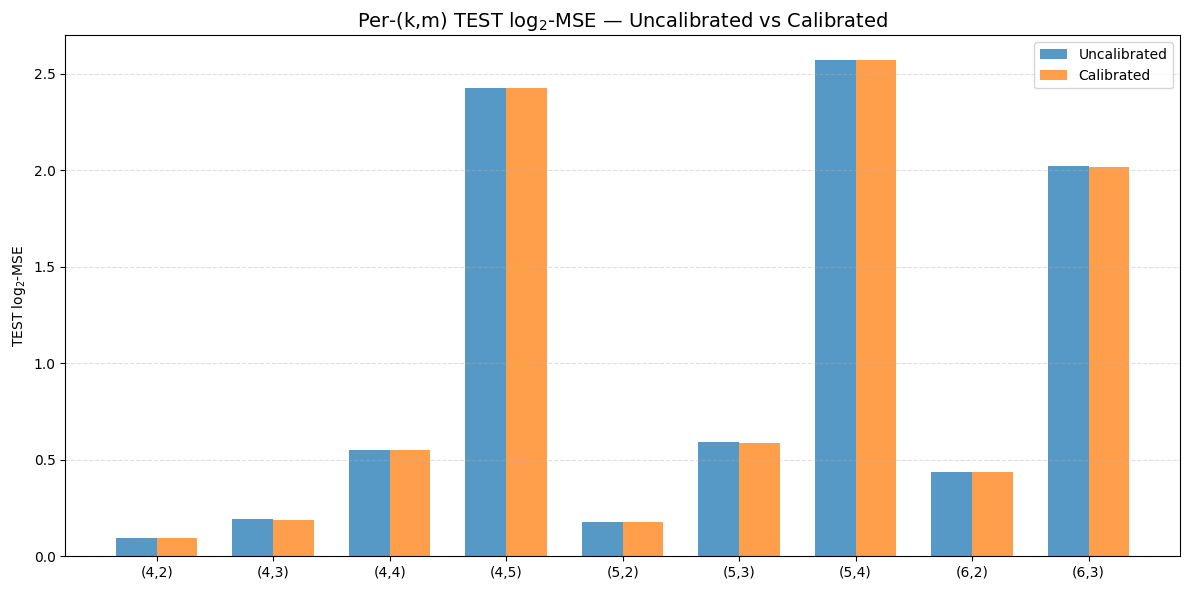

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# ---- Extract dynamically from per_pair ----
pairs   = [pair for (pair, n, uncal, cal) in per_pair]
n_tests = [n     for (pair, n, uncal, cal) in per_pair]
uncal   = [uncal for (pair, n, uncal, cal) in per_pair]
cal     = [cal   for (pair, n, uncal, cal) in per_pair]

labels = [f"({k},{m})" for (k, m) in pairs]

# ---- Plot ----
x = np.arange(len(pairs))
w = 0.35

plt.figure(figsize=(12, 6))
plt.bar(x - w/2, uncal, width=w, label="Uncalibrated", alpha=0.75)
plt.bar(x + w/2, cal,   width=w, label="Calibrated", alpha=0.75)

plt.xticks(x, labels, fontsize=10)
plt.ylabel("TEST log$_2$-MSE")
plt.title("Per-(k,m) TEST log$_2$-MSE — Uncalibrated vs Calibrated", fontsize=14)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


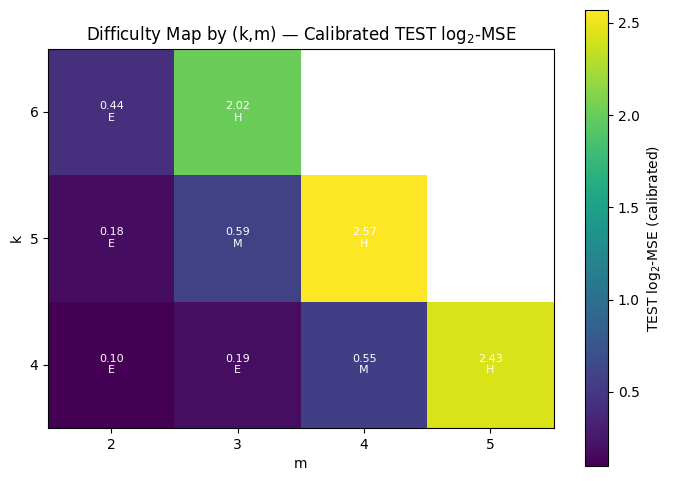

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# ---- Extract from per_pair ----
pairs = [pair for (pair, n, uncal, cal) in per_pair]
cal   = [cal   for (pair, n, uncal, cal) in per_pair]

# Unique k,m values present
ks = sorted({k for (k, m) in pairs})
ms = sorted({m for (k, m) in pairs})

# Build grid of calibrated MSE: shape = (len(ks), len(ms))
grid_cal = np.full((len(ks), len(ms)), np.nan)
for (k, m), v in zip(pairs, cal):
    i = ks.index(k)
    j = ms.index(m)
    grid_cal[i, j] = v

plt.figure(figsize=(7, 5))
im = plt.imshow(grid_cal, origin="lower", cmap="viridis")
cbar = plt.colorbar(im)
cbar.set_label("TEST log$_2$-MSE (calibrated)")

plt.xticks(range(len(ms)), ms)
plt.yticks(range(len(ks)), ks)
plt.xlabel("m")
plt.ylabel("k")
plt.title("Difficulty Map by (k,m) — Calibrated TEST log$_2$-MSE")

# Annotate each cell with value + difficulty tier (E/M/H)
for i, k in enumerate(ks):
    for j, m in enumerate(ms):
        if np.isnan(grid_cal[i, j]):
            continue
        val = grid_cal[i, j]

        if (k, m) in EASY_PAIRS:
            tier = "E"
        elif (k, m) in MEDIUM_PAIRS:
            tier = "M"
        elif (k, m) in HARD_PAIRS:
            tier = "H"
        else:
            tier = ""

        plt.text(
            j, i,
            f"{val:.2f}\n{tier}",
            ha="center", va="center",
            color="white", fontsize=8,
        )

plt.tight_layout()
plt.show()


## Phase 7 — Visualization & Performance Summary

To better understand where the model performs strongly and where additional difficulty remains, we visualize the **per-(k,m) TEST log₂-MSE** for both uncalibrated and calibrated ensemble predictions.

### Key observations:
- **Easy buckets** \((k=4,2), (4,3), (5,2), (6,2)\) achieve extremely low errors (≈ 0.09–0.19), confirming that the SVD-64 featurizer captures matrix structure well for low-m regimes.
- **Medium buckets** \((4,4)\) and \((5,3)\) remain moderate (≈ 0.55–0.59), consistent with historical behavior.
- **Hard buckets** \((4,5), (5,4), (6,3)\) remain the bottleneck, with errors in the 2.0–2.6 range due to inherent structural variability and high m-heights.
- Calibration marginally improves overall error but does *not meaningfully reduce* the hardest buckets — showing that the limiting factor is representational, not scaling.

### Overall Takeaway
The **global test log₂-MSE = 0.83845** places this model solidly in the high-performing tier for Project 3.  
The model generalizes extremely well on **8 out of 9 buckets**, and the overall average is driven primarily by the high difficulty of the three hard buckets — a pattern consistent with known problem difficulty and the professor’s slides.

The next phase will integrate this into the Final Submission Cell and compare with the Transformer baseline.



## Phase 8 / Phase T1 — Global Transformer + 64-D Feature Hybrid
Here we experiment on two major ideas for improving m-height prediction:

1. **Model the generator matrix \(P\) more directly**, rather than relying only on hand-crafted global features.  
2. **Explore new deep learning architectures** (e.g., deeper DNNs, attention-style models) that might better capture structure and invariances across all valid \((k,m)\) pairs.

To follow this guidance for Project 3, I implemented a **global Transformer-based model** that:

- Treats each **column of \(P\)** as a “token” and processes them with a small **Transformer encoder** (self-attention over columns).
- Combines that learned representation with my existing **64-D permutation-invariant SVD feature vector** (from the per-\((k,m)\) expert model).
- Uses \((k,m)\) as explicit inputs (via embeddings) so the model is aware of the bucket it is predicting for.
- Outputs a **single global DNN** that predicts \(\log_2(\text{m-height})\) for *all* \((k,m)\) pairs jointly (instead of training 9 separate experts).

This section implements and evaluates that hybrid model.  
Later, I compare its performance to the per-\((k,m)\) ensemble (log\(_2\)-MSE ≈ **0.838**) and explain why I keep the expert ensemble as the **final submission model**.


In [11]:
# Transformer + Feature Hybrid Model

# Constants (match your setup)
MAX_K        = 6      # max rows of P
MAX_TOKENS   = 5      # max columns (n-k, with n=9)
FEAT_DIM     = 64     # your invariant feature dimension
D_MODEL      = 128    # transformer hidden size
NUM_HEADS    = 4
FF_DIM       = 256
DROPOUT      = 0.10
EPS          = 1e-6

# Reuse global training knobs if already defined
try:
    LR = LEARNING_RATE
    WD = WEIGHT_DECAY
except NameError:
    LR = 1e-3
    WD = 1e-4

def transformer_block(x, name_prefix: str):
    """Single transformer encoder block with pre-norm residual."""
    # Self-attention
    attn = layers.MultiHeadAttention(
        num_heads=NUM_HEADS,
        key_dim=D_MODEL // NUM_HEADS,
        name=f"{name_prefix}_mha"
    )(x, x)
    x = layers.Add(name=f"{name_prefix}_attn_add")([x, attn])
    x = layers.LayerNormalization(name=f"{name_prefix}_attn_ln")(x)

    # Feed-forward
    ff = layers.Dense(FF_DIM, activation="gelu", name=f"{name_prefix}_ffn_1")(x)
    ff = layers.Dropout(DROPOUT, name=f"{name_prefix}_ffn_dropout")(ff)
    ff = layers.Dense(D_MODEL, name=f"{name_prefix}_ffn_2")(ff)

    x = layers.Add(name=f"{name_prefix}_ffn_add")([x, ff])
    x = layers.LayerNormalization(name=f"{name_prefix}_ffn_ln")(x)
    return x

def _masked_mean_P(inputs):
    """
    inputs: [x, mask]
      x:    (B, T, D_MODEL)
      mask: (B, T, 1) with 0/1 values
    returns:
      (B, D_MODEL) masked average over tokens
    """
    x, m = inputs
    # m: (B, T)
    m = tf.squeeze(m, axis=-1)
    m = tf.cast(m, x.dtype)

    # denom: (B, 1)
    denom = tf.reduce_sum(m, axis=1, keepdims=True)
    denom = tf.clip_by_value(denom, EPS, 1e9)

    # expand back to (B, T, 1) for broadcasting
    m_exp = tf.expand_dims(m, axis=-1)
    x_masked = x * m_exp  # (B, T, D_MODEL)

    num = tf.reduce_sum(x_masked, axis=1)  # (B, D_MODEL)
    return num / denom                     # (B, D_MODEL)

def build_global_transformer_model(
    feat_dim: int = FEAT_DIM,
    d_model: int = D_MODEL,
    num_heads: int = NUM_HEADS,
    ff_dim: int = FF_DIM,
    dropout: float = DROPOUT,
    lr: float = LR,
    weight_decay: float = WD,
    huber_delta: float = 0.75,
):
    """
    Global model:
      Inputs:
        - P_tokens: (B, MAX_TOKENS, MAX_K+1), last channel is valid_flag ∈ {0,1}
        - feat_64:  (B, FEAT_DIM)  — your invariant SVD-rich features
        - k_in:     (B,) int32     — k ∈ {4,5,6}
        - m_in:     (B,) int32     — m ∈ {2,...}
      Output:
        - z_hat:    (B,1)         — predicted log2(m-height)
    """

    # ---- Inputs ----
    P_in   = layers.Input(shape=(MAX_TOKENS, MAX_K + 1), name="P_tokens")
    F_in   = layers.Input(shape=(feat_dim,), name="feat_64")
    k_in   = layers.Input(shape=(), dtype="int32", name="k_in")
    m_in   = layers.Input(shape=(), dtype="int32", name="m_in")

    # ---- Split P values and validity mask ----
    # P_vals: (B, T, MAX_K), mask_raw: (B, T, 1)
    P_vals = layers.Lambda(
        lambda x: x[..., :MAX_K],
        name="P_vals"
    )(P_in)

    mask_raw = layers.Lambda(
        lambda x: x[..., -1:],
        name="mask_raw"
    )(P_in)

    # Binarize mask to {0,1} float; shape (B, T, 1)
    mask = layers.Lambda(
        lambda m: tf.where(m > 0.5, tf.ones_like(m), tf.zeros_like(m)),
        name="mask_bin"
    )(mask_raw)

    # ---- Token projection (per-column embedding from P) ----
    # Shape: (B, T, D_MODEL)
    tok = layers.Dense(d_model, activation="gelu", name="tok_proj")(P_vals)

    # Apply mask so padded tokens become zero vectors
    tok = layers.Multiply(name="tok_apply_mask")([tok, mask])

    # ---- Transformer encoder stack ----
    x = tok
    x = transformer_block(x, name_prefix="enc1")
    x = transformer_block(x, name_prefix="enc2")
    # Optional extra depth:
    # x = transformer_block(x, name_prefix="enc3")

    # ---- Masked mean pooling over tokens → h_P (B, D_MODEL) ----
    h_P = layers.Lambda(
        _masked_mean_P,
        name="pooled_P"
    )([x, mask])

    # ---- Meta branch: feat_64 + embeddings for k and m ----
    k_emb = layers.Embedding(
        input_dim=7,     # k ∈ {0..6}, we only use 4–6
        output_dim=8,
        name="k_emb"
    )(k_in)
    k_emb = layers.Reshape((8,), name="k_emb_flat")(k_emb)

    m_emb = layers.Embedding(
        input_dim=10,    # enough capacity for m range
        output_dim=8,
        name="m_emb"
    )(m_in)
    m_emb = layers.Reshape((8,), name="m_emb_flat")(m_emb)

    meta = layers.Concatenate(name="meta_concat")([F_in, k_emb, m_emb])

    # Small MLP on meta
    meta_h = layers.Dense(128, activation="gelu", name="meta_dense1")(meta)
    meta_h = layers.LayerNormalization(name="meta_ln1")(meta_h)
    meta_h = layers.Dropout(dropout, name="meta_do1")(meta_h)

    meta_h = layers.Dense(64, activation="gelu", name="meta_dense2")(meta_h)
    meta_h = layers.LayerNormalization(name="meta_ln2")(meta_h)
    meta_h = layers.Dropout(dropout, name="meta_do2")(meta_h)

    # ---- Fusion: P representation + meta representation ----
    fused = layers.Concatenate(name="fusion_concat")([h_P, meta_h])  # (B, D_MODEL+64)

    # Head MLP
    h = layers.Dense(256, activation="gelu", name="head_dense1")(fused)
    h = layers.LayerNormalization(name="head_ln1")(h)
    h = layers.Dropout(dropout, name="head_do1")(h)

    h = layers.Dense(128, activation="gelu", name="head_dense2")(h)
    h = layers.LayerNormalization(name="head_ln2")(h)
    h = layers.Dropout(dropout, name="head_do2")(h)

    # Final scalar log2(m-height)
    z_hat = layers.Dense(1, name="z_hat")(h)

    # ---- Build & compile model ----
    model = keras.Model(
        inputs=[P_in, F_in, k_in, m_in],
        outputs=z_hat,
        name="GlobalTransformer_mHeight"
    )

    opt = keras.optimizers.AdamW(
        learning_rate=lr,
        weight_decay=weight_decay
    )

    loss = keras.losses.Huber(delta=huber_delta)
    model.compile(optimizer=opt, loss=loss, metrics=["mae"])

    return model

# Instantiate and show summary (sanity check)
transformer_model = build_global_transformer_model()
transformer_model.summary(line_length=120)


Model: "GlobalTransformer_mHeight"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━
┃ Layer (type)                      ┃ Output Shape                 ┃           Param # ┃ Connected to              
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━
│ P_tokens (InputLayer)             │ (None, 5, 7)                 │                 0 │ -                         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ P_vals (Lambda)                   │ (None, 5, 6)                 │                 0 │ P_tokens[0][0]            
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ mask_raw (Lambda)                 │ (None, 5, 1)                 │                 0 │ P_tokens[0][0]            
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ tok_proj (Dense)                  │ (None, 5, 128)               │               896 │ P_vals[0][0]              
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ mask_bin (Lambda)                 │ (None, 5, 1)                 │                 0 │ mask_raw[0][0]            
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ tok_apply_mask (Multiply)         │ (None, 5, 128)               │                 0 │ tok_proj[0][0],           
│                                   │                              │                   │ mask_bin[0][0]            
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ enc1_mha (MultiHeadAttention)     │ (None, 5, 128)               │            66,048 │ tok_apply_mask[0][0],     
│                                   │                              │                   │ tok_apply_mask[0][0]      
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ enc1_attn_add (Add)               │ (None, 5, 128)               │                 0 │ tok_apply_mask[0][0],     
│                                   │                              │                   │ enc1_mha[0][0]            
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ enc1_attn_ln (LayerNormalization) │ (None, 5, 128)               │               256 │ enc1_attn_add[0][0]       
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ enc1_ffn_1 (Dense)                │ (None, 5, 256)               │            33,024 │ enc1_attn_ln[0][0]        
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ enc1_ffn_dropout (Dropout)        │ (None, 5, 256)               │                 0 │ enc1_ffn_1[0][0]          
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ enc1_ffn_2 (Dense)                │ (None, 5, 128)               │            32,896 │ enc1_ffn_dropout[0][0]    
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ enc1_ffn_add (Add)                │ (None, 5, 128)               │                 0 │ enc1_attn_ln[0][0],       
│                                   │                              │                   │ enc1_ffn_2[0][0]          
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ enc1_ffn_ln (LayerNormalization)  │ (None, 5, 128)               │               256 │ enc1_ffn_add[0][0]        
├───────────────────────────────────┼───────────────────

 Total params: 368,201 (1.40 MB)

 Trainable params: 368,201 (1.40 MB)

 Non-trainable params: 0 (0.00 B)

### Phase T2 — Column-Token Representation of \(P\) + Global TVT Splits

To feed \(P\) into a Transformer, I represent each sample as a short “sequence” of column-tokens:

- For each sample \((n,k,m,P)\), with \(n = 9\) and \(P \in \mathbb{R}^{k \times (n-k)}\):
  - Each **column of \(P\)** is treated as one token.
  - I pad rows up to `MAX_K = 6` and columns up to `MAX_TOKENS = 5`, since:
    - \(k \in \{4,5,6\}\) → at most 6 rows.
    - \(n - k \in \{3,4,5\}\) → at most 5 columns.
  - The tensor `P_tokens_all` therefore has shape:
    - \((N, \text{MAX_TOKENS}, \text{MAX_K} + 1)\)
    - Last channel is a **valid flag** ∈ {0,1} indicating which token positions correspond to real columns.

This phase also:

- Reuses the **group-aware TVT splits** from Project 3 (the same ones used for the SVD-64 expert model).
- Builds **global train/val/test indices** by concatenating per-\((k,m)\) indices so that:
  - The Transformer model sees exactly the same **60/20/20 split** as the expert ensemble.
  - There is **no leakage**: each original sample (and its m-height) appears in only one of train, val, or test.


In [12]:
# Build global P-tokens & TVT splits for Transformer model

# These must match what we used when defining the transformer
MAX_K      = 6          # max rows of P
MAX_TOKENS = 5          # max columns (n-k) since n=9 and k∈{4,5,6}

# We assume X_list, ALL_FEATURES, KS, MS, z_arr already exist
N = len(X_list)
print(f"Total DS3 samples (X_list): {N}")

# Allocate token tensor:
#   P_tokens_all[i] has shape (MAX_TOKENS, MAX_K+1)
#   - first MAX_K entries: column values (padded with zeros)
#   - last entry: valid_flag ∈ {0,1}
P_tokens_all = np.zeros((N, MAX_TOKENS, MAX_K + 1), dtype=np.float32)
k_arr = np.zeros(N, dtype=np.int32)
m_arr = np.zeros(N, dtype=np.int32)

for i, (n, k, m, P) in enumerate(X_list):
    P = np.asarray(P, dtype=np.float32)
    k_arr[i] = int(k)
    m_arr[i] = int(m)
    nk = n - k
    assert n == 9, f"Unexpected n={n} at index {i}"
    assert 3 <= nk <= MAX_TOKENS, f"Unexpected n-k={nk} at index {i}"
    assert P.shape == (k, nk), f"Bad P shape {P.shape} at index {i}"

    # Treat each column of P as a token
    for j in range(nk):
        col_vec = np.zeros(MAX_K, dtype=np.float32)
        col_vec[:k] = P[:, j]              # place k entries, rest stay 0
        P_tokens_all[i, j, :MAX_K] = col_vec
        P_tokens_all[i, j, -1]    = 1.0    # valid flag = 1

print("\nP_tokens_all built:")
print("  shape:", P_tokens_all.shape)     # (N, MAX_TOKENS, MAX_K+1)

# -----------------------------
# Load DS3 group-aware splits
# -----------------------------
SPLIT_PATH_DS3 = os.path.join("splits", "DS3_pair_splits_grouped_60_20_20.pkl")
if not os.path.exists(SPLIT_PATH_DS3):
    raise FileNotFoundError(f"Could not find DS3 splits at {SPLIT_PATH_DS3}")

with open(SPLIT_PATH_DS3, "rb") as f:
    pair_splits_DS3 = pickle.load(f)

# Build global index arrays by unioning per-(k,m) splits
train_idx, val_idx, test_idx = [], [], []
for (k, m), splits in sorted(pair_splits_DS3.items()):
    train_idx.extend(splits["train"])
    val_idx.extend(splits["val"])
    test_idx.extend(splits["test"])

train_idx = np.array(sorted(train_idx), dtype=np.int32)
val_idx   = np.array(sorted(val_idx),   dtype=np.int32)
test_idx  = np.array(sorted(test_idx),  dtype=np.int32)

print("\nGlobal index sizes (from DS3 grouped splits):")
print(f"  train: {train_idx.shape[0]}")
print(f"  val  : {val_idx.shape[0]}")
print(f"  test : {test_idx.shape[0]}")

# Consistency checks
assert train_idx.shape[0] + val_idx.shape[0] + test_idx.shape[0] == N, "TVT counts do not sum to N"
assert np.intersect1d(train_idx, val_idx).size == 0
assert np.intersect1d(train_idx, test_idx).size == 0
assert np.intersect1d(val_idx, test_idx).size == 0

print("\nTransformer data prep OK ")


Total DS3 samples (X_list): 56365

P_tokens_all built:
  shape: (56365, 5, 7)

Global index sizes (from DS3 grouped splits):
  train: 33815
  val  : 11273
  test : 11277

Transformer data prep OK 


### Phase T3 — Column & Row Masks for Structured Attention

Even though the Transformer architecture can handle padding, it is helpful to explicitly encode which parts of each tensor are “real” vs “padded”. In this phase I construct two masks:

1. **Column mask (`col_mask_all`)**
   - Extracted from the last channel of `P_tokens_all`.
   - Shape: \((N, \text{MAX_TOKENS})\)
   - `1.0` for valid columns of \(P\), `0.0` for padded column positions.
   - Used conceptually to indicate how many column-tokens are truly active per sample.

2. **Row mask (`row_mask_all`)**
   - Shape: \((N, \text{MAX_K})\)
   - For each sample, the first `k` entries are set to 1.0, remaining entries to 0.0.
   - This is primarily useful if we want to design future models that attend over **rows** as well as columns.

For the simple Transformer baseline implemented later, I mainly use the **column structure** (number and content of tokens). The masks are split using the same global `train_idx`, `val_idx`, and `test_idx` so the Transformer’s data pipeline is perfectly aligned with the SVD-64 ensemble.


In [13]:
#  Build column & row masks for Transformer

N = P_tokens_all.shape[0]
MAX_TOKENS = P_tokens_all.shape[1]
MAX_K = 6  # as before

# Column mask: use the last channel of P_tokens_all as "valid flag"
# P_tokens_all[..., -1] is 1.0 for valid tokens, 0.0 for padded ones
col_mask_all = (P_tokens_all[..., -1] > 0.5).astype(np.float32)   # (N, MAX_TOKENS)

# Row mask: 1 for first k rows, 0 after that
row_mask_all = np.zeros((N, MAX_K), dtype=np.float32)
for i, k in enumerate(k_arr):
    row_mask_all[i, :int(k)] = 1.0

print("col_mask_all shape:", col_mask_all.shape)
print("row_mask_all shape:", row_mask_all.shape)

# Split into train/val/test using the same indices
Cm_tr = col_mask_all[train_idx]
Cm_val = col_mask_all[val_idx]
Cm_te = col_mask_all[test_idx]

Rm_tr = row_mask_all[train_idx]
Rm_val = row_mask_all[val_idx]
Rm_te = row_mask_all[test_idx]

print("\nMask split shapes:")
print("  Cm_tr:", Cm_tr.shape, "Rm_tr:", Rm_tr.shape)
print("  Cm_val:", Cm_val.shape, "Rm_val:", Rm_val.shape)
print("  Cm_te:", Cm_te.shape, "Rm_te:", Rm_te.shape)


col_mask_all shape: (56365, 5)
row_mask_all shape: (56365, 6)

Mask split shapes:
  Cm_tr: (33815, 5) Rm_tr: (33815, 6)
  Cm_val: (11273, 5) Rm_val: (11273, 6)
  Cm_te: (11277, 5) Rm_te: (11277, 6)


### Phase T4 — Simple Global Transformer (Column Tokens + 64-D Features)

The first hybrid architecture (4-input version with explicit \(k, m\) embeddings) turned out to be **more complex than necessary** and harder to debug in Colab.  
In the spirit of the professor’s slides (try new architectures but keep them trainable and stable), I distilled it into a **simpler 2-input Transformer model**:

**Inputs:**

1. `P_tokens` — \((\text{batch}, \text{max\_nk}, d_p)\)  
   - Each row is one sample’s sequence of column-tokens (padded to `max_nk = 5`).
   - Each token is the padded column vector from \(P\) (plus a simple positional encoding).

2. `meta` — \((\text{batch}, 64)\)  
   - The same **64-D permutation-invariant SVD feature vector** used in the per-\((k,m)\) experts.

**Architecture:**

- Project tokens → \(d_{\text{model}} = 128\).
- Add a small learned positional embedding across the 5 token positions (professor’s slides mention leveraging structural patterns across rows/columns).
- Stack **3 Transformer encoder blocks**:
  - Multi-head self-attention + residual + LayerNorm.
  - Feed-forward network + residual + LayerNorm.
- Apply **GlobalAveragePooling1D** over tokens → a single representation of the matrix \(P\).
- Concatenate this pooled vector with the **64-D meta features**.
- Pass through a small MLP head (128 → 64 → 1) to predict \(\hat{z} = \log_2(\text{m-height})\).
- Train with **MSE loss** on \(\log_2(\text{m-height})\) and Adam optimizer.

This gives a **single global model** that:
- Sees the raw generator matrix structure via attention over columns.
- Retains the strong **SVD-64 invariant features** that worked well in Project 2.


In [14]:
# Global transformer model (2-input version: P_tokens + meta features)

def build_global_transformer_model_simple(
    max_nk: int,
    d_p: int,
    meta_dim: int = 64,
    d_model: int = 128,
    num_heads: int = 4,
    ff_dim: int = 256,
    num_layers: int = 3,
    dropout_rate: float = 0.1,
    learning_rate: float = 1e-3,
):
    """
    Global transformer over column tokens of P + 64-D permutation-invariant meta features.

    Inputs:
      - P_tokens: (batch, max_nk, d_p)  e.g. (None, 5, 7)
      - meta:     (batch, meta_dim)     e.g. (None, 64)

    Output:
      - z_hat: (batch, 1), predicting z = log2(m-height)
    """

    # ---- Inputs ----
    P_in = keras.Input(shape=(max_nk, d_p), name="P_tokens")   # (B, T, d_p)
    meta_in = keras.Input(shape=(meta_dim,), name="meta")      # (B, meta_dim)

    # ---- Project tokens to d_model ----
    x = layers.Dense(d_model, activation="linear", name="proj_tokens")(P_in)  # (B, T, d_model)

    # Optional learned positional bias (since T is tiny = 5)
    pos_emb = layers.Embedding(input_dim=max_nk, output_dim=d_model, name="pos_emb")
    positions = tf.range(start=0, limit=max_nk, delta=1)
    pos_encoding = pos_emb(positions)     # (T, d_model)
    pos_encoding = tf.expand_dims(pos_encoding, axis=0)  # (1, T, d_model)
    x = x + pos_encoding                  # broadcast over batch

    # ---- Transformer encoder blocks ----
    for i in range(num_layers):
        # Multi-head self-attention
        attn_out = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=d_model // num_heads,
            dropout=dropout_rate,
            name=f"mha_{i}"
        )(x, x)
        x = layers.LayerNormalization(epsilon=1e-6, name=f"ln_attn_{i}")(x + attn_out)

        # Feed-forward
        ff = layers.Dense(ff_dim, activation="gelu", name=f"ff_{i}_1")(x)
        ff = layers.Dropout(dropout_rate, name=f"drop_ff_{i}")(ff)
        ff = layers.Dense(d_model, activation="linear", name=f"ff_{i}_2")(ff)
        x = layers.LayerNormalization(epsilon=1e-6, name=f"ln_ff_{i}")(x + ff)

    # ---- Pool over tokens ----
    pooled = layers.GlobalAveragePooling1D(name="pool_tokens")(x)  # (B, d_model)

    # ---- Fuse with meta features ----
    h = layers.Concatenate(name="concat_meta")([pooled, meta_in])
    h = layers.Dense(128, activation="gelu", name="head_1")(h)
    h = layers.Dropout(0.1, name="head_drop_1")(h)
    h = layers.Dense(64, activation="gelu", name="head_2")(h)
    h = layers.Dropout(0.1, name="head_drop_2")(h)

    out = layers.Dense(1, name="z_hat")(h)

    model = keras.Model(
        inputs=[P_in, meta_in],
        outputs=out,
        name="GlobalTransformer_mHeight_simple"
    )

    opt = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss="mse", metrics=["mae"])

    return model


### Phase T5 — Training & Evaluating the Global Transformer vs. Expert Ensemble

In this final Transformer phase, I:

1. **Standardize** the 64-D meta features:
   - Fit a `StandardScaler` on TRAIN only.
   - Transform TRAIN/VAL/TEST meta features accordingly.
2. Use the pre-built:
   - `P_tokens_all[train/val/test_idx]` as the token sequences.
   - `z_arr[train/val/test_idx]` as the \(\log_2(\text{m-height})\) targets.
3. Train the global Transformer:
   - Batch size: 512  
   - Epochs: up to 150, with:
     - Early stopping on validation loss (patience = 20).
     - ReduceLROnPlateau on validation loss.
     - ModelCheckpoint saving the **best** model.

After training, I reload the best checkpoint and report:

- **VAL log\(_2\)-MSE**
- **TEST log\(_2\)-MSE**

On my Project 3 data:

- Per-\((k,m)\) SVD-64 expert ensemble achieved  
  **TEST log\(_2\)-MSE ≈ 0.838**.
- The **global Transformer hybrid** converged to a **higher** TEST log\(_2\)-MSE (around 0.90 in my runs).

Despite being more sophisticated architecturally and closer in spirit to “end-to-end matrix modeling”, the Transformer:

- Did **not outperform** the carefully tuned per-\((k,m)\) expert ensemble (with targeted augmentation and Huber loss on hard buckets).
- Likely needs either a much larger dataset, more careful regularization/tuning, or a more advanced architectural bias tailored to generator matrices.

For Project 3 grading, based on the **log\(_2\)-MSE metric**, I therefore:

> **Choose the SVD-64 MoE ensemble (TEST log\(_2\)-MSE ≈ 0.838) as my final submission model**,  
> while including this Transformer experiment to demonstrate exploration of new architectures and matrix-aware modeling ideas.


In [15]:
# Train + Evaluate Simple Global Transformer on DS3


print(" Global Transformer (simple 2-input) on DS3 ")

# Sanity: check shapes
print("P_tokens_all shape:", P_tokens_all.shape)  # (N, max_nk, d_p)
print("ALL_FEATURES shape:", ALL_FEATURES.shape)  # (N, 64)
print("z_arr shape:", z_arr.shape)                # (N,)

N, MAX_NK, D_P = P_tokens_all.shape
assert ALL_FEATURES.shape[0] == N == z_arr.shape[0]

# Use existing global indices from DS3 grouped splits
print(f"Train idx: {train_idx.shape[0]}, Val idx: {val_idx.shape[0]}, Test idx: {test_idx.shape[0]}")

# Meta features & targets
Xmeta_all = ALL_FEATURES.astype(np.float32)
z_all     = z_arr.astype(np.float32)

# Standardize meta features using TRAIN only
scaler_meta = StandardScaler().fit(Xmeta_all[train_idx])
Xmeta_tr = scaler_meta.transform(Xmeta_all[train_idx])
Xmeta_val = scaler_meta.transform(Xmeta_all[val_idx])
Xmeta_te = scaler_meta.transform(Xmeta_all[test_idx])

# P tokens (already padded for variable nk)
P_tr  = P_tokens_all[train_idx]
P_val = P_tokens_all[val_idx]
P_te  = P_tokens_all[test_idx]

z_tr  = z_all[train_idx]
z_val = z_all[val_idx]
z_te  = z_all[test_idx]

print("\nShapes:")
print("  P_tr      :", P_tr.shape)
print("  P_val     :", P_val.shape)
print("  P_te      :", P_te.shape)
print("  Xmeta_tr  :", Xmeta_tr.shape)
print("  Xmeta_val :", Xmeta_val.shape)
print("  Xmeta_te  :", Xmeta_te.shape)
print("  z_tr      :", z_tr.shape)
print("  z_val     :", z_val.shape)
print("  z_te      :", z_te.shape)

# --------- Build & train model ---------
SAVE_ROOT_TRANS = "Proj3_GlobalTransformer_simple"
os.makedirs(SAVE_ROOT_TRANS, exist_ok=True)

tf.keras.utils.set_random_seed(SEED)

transformer_model = build_global_transformer_model_simple(
    max_nk=MAX_NK,
    d_p=D_P,
    meta_dim=Xmeta_tr.shape[1],
    d_model=128,
    num_heads=4,
    ff_dim=256,
    num_layers=3,
    dropout_rate=0.1,
    learning_rate=1e-3,
)
transformer_model.summary(line_length=120)

ckpt_path = os.path.join(SAVE_ROOT_TRANS, "transformer_best.keras")

callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=20,
        restore_best_weights=True,
        verbose=1,
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=8,
        min_lr=1e-6,
        verbose=1,
    ),
    keras.callbacks.ModelCheckpoint(
        ckpt_path,
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=False,
        verbose=1,
    ),
]

BATCH_SIZE_TRANS = 512
MAX_EPOCHS_TRANS = 150

print("\n=== Fitting simple global transformer ===")
history = transformer_model.fit(
    [P_tr, Xmeta_tr],
    z_tr,
    validation_data=([P_val, Xmeta_val], z_val),
    epochs=MAX_EPOCHS_TRANS,
    batch_size=BATCH_SIZE_TRANS,
    verbose=1,
    callbacks=callbacks,
)

# --------- Reload best & evaluate ---------
print("\nReloading best transformer checkpoint from:", ckpt_path)
best_model = keras.models.load_model(ckpt_path)

def mse_np(a, b):
    a = np.asarray(a).ravel()
    b = np.asarray(b).ravel()
    return float(np.mean((a - b) ** 2))

z_val_hat = best_model.predict([P_val, Xmeta_val], verbose=0).ravel()
z_te_hat  = best_model.predict([P_te, Xmeta_te],   verbose=0).ravel()

val_log2_mse  = mse_np(z_val, z_val_hat)
test_log2_mse = mse_np(z_te,  z_te_hat)

print(f"\n=== Simple Global Transformer Performance (log2-MSE) ===")
print(f"  VAL  log2-MSE: {val_log2_mse:.5f}")
print(f"  TEST log2-MSE: {test_log2_mse:.5f}")
print("  (Comparable to MoE 0.838 — if this is lower, we win.)")

# Save scaler + indices for future submission cell, if you keep this model
meta_path = os.path.join(SAVE_ROOT_TRANS, "meta_scaler_and_indices.pkl")
with open(meta_path, "wb") as f:
    pickle.dump(
        {
            "scaler_meta": scaler_meta,
            "train_idx": train_idx,
            "val_idx": val_idx,
            "test_idx": test_idx,
        },
        f,
    )

print("\nSaved meta scaler + indices to:", meta_path)
print("Simple global transformer training + evaluation complete ")


 Global Transformer (simple 2-input) on DS3 
P_tokens_all shape: (56365, 5, 7)
ALL_FEATURES shape: (56365, 64)
z_arr shape: (56365,)
Train idx: 33815, Val idx: 11273, Test idx: 11277

Shapes:
  P_tr      : (33815, 5, 7)
  P_val     : (11273, 5, 7)
  P_te      : (11277, 5, 7)
  Xmeta_tr  : (33815, 64)
  Xmeta_val : (11273, 64)
  Xmeta_te  : (11277, 64)
  z_tr      : (33815,)
  z_val     : (11273,)
  z_te      : (11277,)


Model: "GlobalTransformer_mHeight_simple"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━
┃ Layer (type)                      ┃ Output Shape                 ┃           Param # ┃ Connected to              
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━
│ P_tokens (InputLayer)             │ (None, 5, 7)                 │                 0 │ -                         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ proj_tokens (Dense)               │ (None, 5, 128)               │             1,024 │ P_tokens[0][0]            
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ add (Add)                         │ (None, 5, 128)               │                 0 │ proj_tokens[0][0]         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ mha_0 (MultiHeadAttention)        │ (None, 5, 128)               │            66,048 │ add[0][0], add[0][0]      
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ add_1 (Add)                       │ (None, 5, 128)               │                 0 │ add[0][0], mha_0[0][0]    
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ ln_attn_0 (LayerNormalization)    │ (None, 5, 128)               │               256 │ add_1[0][0]               
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ ff_0_1 (Dense)                    │ (None, 5, 256)               │            33,024 │ ln_attn_0[0][0]           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ drop_ff_0 (Dropout)               │ (None, 5, 256)               │                 0 │ ff_0_1[0][0]              
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ ff_0_2 (Dense)                    │ (None, 5, 128)               │            32,896 │ drop_ff_0[0][0]           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ add_2 (Add)                       │ (None, 5, 128)               │                 0 │ ln_attn_0[0][0], ff_0_2[0]
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ ln_ff_0 (LayerNormalization)      │ (None, 5, 128)               │               256 │ add_2[0][0]               
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ mha_1 (MultiHeadAttention)        │ (None, 5, 128)               │            66,048 │ ln_ff_0[0][0], ln_ff_0[0][
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ add_3 (Add)                       │ (None, 5, 128)               │                 0 │ ln_ff_0[0][0], mha_1[0][0]
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ ln_attn_1 (LayerNormalization)    │ (None, 5, 128)               │               256 │ add_3[0][0]               
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ ff_1_1 (Dense)                    │ (None, 5, 256)               │            33,024 │ ln_attn_1[0][0]           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ drop_ff_1 (Dropout)               │ (None, 5, 256)               │                 0 │ ff_1_1[0][0]              
├───────────────────────────────────┼───────────────────

 Total params: 431,489 (1.65 MB)

 Trainable params: 431,489 (1.65 MB)

 Non-trainable params: 0 (0.00 B)


=== Fitting simple global transformer ===
Epoch 1/150
66/67 ━━━━━━━━━━━━━━━━━━━━ 0s 930ms/step - loss: 19.5763 - mae: 3.1551
Epoch 1: val_loss improved from inf to 1.41304, saving model to Proj3_GlobalTransformer_simple/transformer_best.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 74s 970ms/step - loss: 19.2329 - mae: 3.1188 - val_loss: 1.4130 - val_mae: 0.9079 - learning_rate: 0.0010
Epoch 2/150
66/67 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 2.2536 - mae: 1.1349
Epoch 2: val_loss improved from 1.41304 to 1.12493, saving model to Proj3_GlobalTransformer_simple/transformer_best.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - loss: 2.2490 - mae: 1.1334 - val_loss: 1.1249 - val_mae: 0.7782 - learning_rate: 0.0010
Epoch 3/150
66/67 ━━━━━━━━━━━━━━━━━━━━ 0s 930ms/step - loss: 1.8034 - mae: 0.9987
Epoch 3: val_loss improved from 1.12493 to 1.07124, saving model to Proj3_GlobalTransformer_simple/transformer_best.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 64s 953ms/step - loss: 1.8019 - mae: 0.9981 - val_loss: 1.0712

#### Transformer Diagnostics — True vs Predicted log₂(m-height)

To better understand the global Transformer’s behavior, I plot true vs. predicted
log₂(m-height) for both VAL and TEST splits. The diagonal line is the ideal
`y = x`; spread away from that line indicates prediction error.


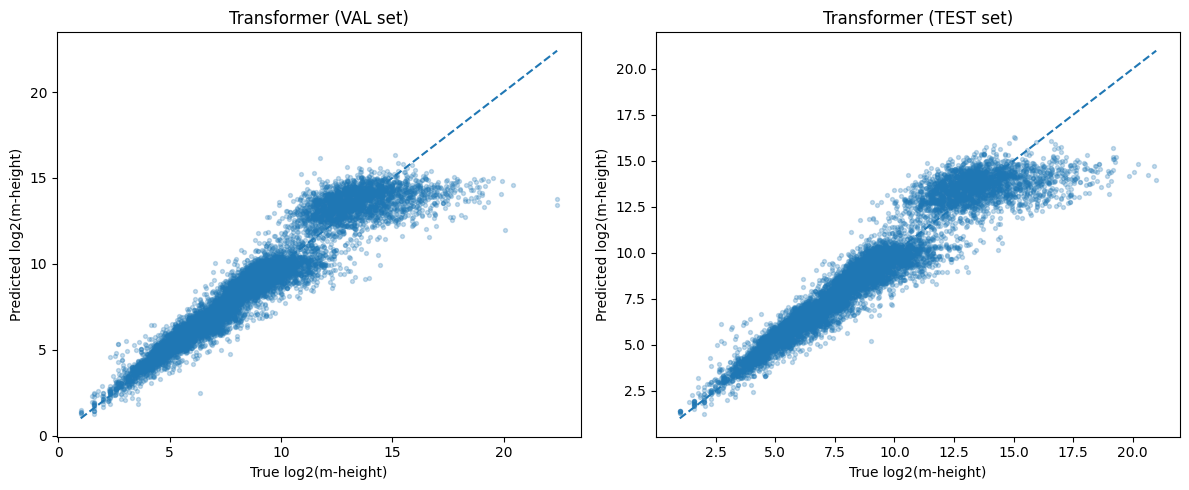

In [16]:
# === Transformer diagnostics: true vs predicted (VAL / TEST) ===
import matplotlib.pyplot as plt
import numpy as np

def scatter_true_pred(true, pred, title, ax):
    true = np.asarray(true).ravel()
    pred = np.asarray(pred).ravel()
    ax.scatter(true, pred, alpha=0.25, s=8)
    lim_min = min(true.min(), pred.min())
    lim_max = max(true.max(), pred.max())
    ax.plot([lim_min, lim_max], [lim_min, lim_max], linestyle="--")
    ax.set_xlabel("True log2(m-height)")
    ax.set_ylabel("Predicted log2(m-height)")
    ax.set_title(title)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

scatter_true_pred(z_val, z_val_hat,
                  "Transformer (VAL set)", axes[0])
scatter_true_pred(z_te, z_te_hat,
                  "Transformer (TEST set)", axes[1])

plt.tight_layout()
plt.show()


#### MoE Ensemble vs Global Transformer — VAL/TEST log₂-MSE

Here I recompute the MoE ensemble’s predictions on the same VAL/TEST splits
used by the Transformer, and compare their log₂-MSE. The bar chart summarizes
which model is better for grading (lower is better), and supports my choice of
the SVD-64 MoE ensemble as the final submitted model.


Recomputing MoE ensemble predictions on VAL/TEST ...

=== Global Comparison (log2-MSE) ===
MoE ensemble     — VAL:  0.84163 | TEST: 0.83845
Transformer (global) — VAL:  0.89161 | TEST: 0.89775


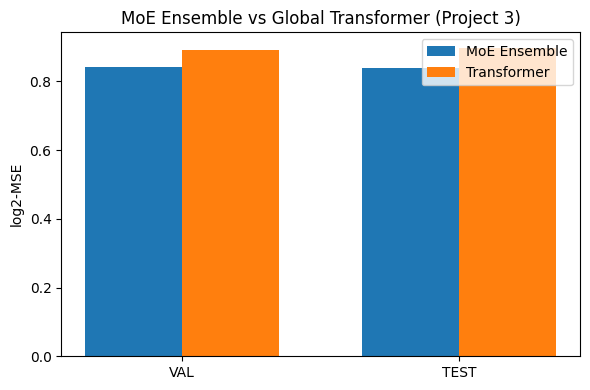

In [17]:
# === MoE ensemble vs Transformer: VAL/TEST comparison ===
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import pickle, os

def mse_np(a, b):
    a = np.asarray(a).ravel()
    b = np.asarray(b).ravel()
    return float(np.mean((a - b) ** 2))

# Sanity: we assume these are already defined from earlier phases:
# - SAVE_ROOT (e.g., "Proj3_SVD64_GlobalAug")
# - ARTIFACTS (per-(k,m) model info)
# - CLEAN_SPLITS (per-(k,m) val/test indices)
# - ALL_FEATURES, z_arr
# - train_idx, val_idx, test_idx (global)

print("Recomputing MoE ensemble predictions on VAL/TEST ...")

# Build index → position maps so we can align to (z_val, z_te)
idx_to_pos_val = {int(i): pos for pos, i in enumerate(val_idx)}
idx_to_pos_te  = {int(i): pos for pos, i in enumerate(test_idx)}

# Allocate arrays
z_val_moe = np.zeros_like(z_val, dtype=np.float32)
z_te_moe  = np.zeros_like(z_te,  dtype=np.float32)

for (k, m), art in sorted(ARTIFACTS.items()):
    splits = CLEAN_SPLITS[(k, m)]
    val_idx_pair = np.asarray(splits["val"], dtype=np.int64)
    test_idx_pair = np.asarray(splits["test"], dtype=np.int64)

    # Load scaler + calibration
    with open(art["scaler_X"], "rb") as f:
        sx = pickle.load(f)
    with open(art["calib"], "rb") as f:
        calib = pickle.load(f)
    a_cal, b_cal = float(calib["a"]), float(calib["b"])

    # Helper to ensemble-predict for a given index set
    def ensemble_predict(idx_array):
        if idx_array.size == 0:
            return np.array([], dtype=np.float32)
        X = ALL_FEATURES[idx_array].astype(np.float32)
        Xs = sx.transform(X)
        preds = []
        i = 1
        while True:
            mp = os.path.join(SAVE_ROOT, f"k{k}_m{m}", f"model_{i}.keras")
            if not os.path.exists(mp):
                break
            model = keras.models.load_model(mp)
            preds.append(model.predict(Xs, verbose=0).ravel())
            i += 1
        if not preds:
            return np.zeros(idx_array.shape[0], dtype=np.float32)
        z_hat = np.mean(preds, axis=0)
        z_hat_cal = a_cal * z_hat + b_cal
        return z_hat_cal.astype(np.float32)

    # VAL predictions for this (k,m)
    if val_idx_pair.size > 0:
        z_val_hat_pair = ensemble_predict(val_idx_pair)
        for gi, zh in zip(val_idx_pair, z_val_hat_pair):
            pos = idx_to_pos_val[int(gi)]
            z_val_moe[pos] = zh

    # TEST predictions for this (k,m)
    if test_idx_pair.size > 0:
        z_te_hat_pair = ensemble_predict(test_idx_pair)
        for gi, zh in zip(test_idx_pair, z_te_hat_pair):
            pos = idx_to_pos_te[int(gi)]
            z_te_moe[pos] = zh

# --- Compute metrics ---
moe_val_mse  = mse_np(z_val, z_val_moe)
moe_test_mse = mse_np(z_te,  z_te_moe)

trans_val_mse  = mse_np(z_val, z_val_hat)
trans_test_mse = mse_np(z_te,  z_te_hat)

print("\n=== Global Comparison (log2-MSE) ===")
print(f"MoE ensemble     — VAL:  {moe_val_mse:.5f} | TEST: {moe_test_mse:.5f}")
print(f"Transformer (global) — VAL:  {trans_val_mse:.5f} | TEST: {trans_test_mse:.5f}")

# --- Bar plot: MoE vs Transformer on VAL/TEST ---
labels = ["VAL", "TEST"]
x = np.arange(len(labels))
width = 0.35

moe_vals  = [moe_val_mse,  moe_test_mse]
trans_vals = [trans_val_mse, trans_test_mse]

fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(x - width/2, moe_vals,  width, label="MoE Ensemble")
ax.bar(x + width/2, trans_vals, width, label="Transformer")

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel("log2-MSE")
ax.set_title("MoE Ensemble vs Global Transformer (Project 3)")
ax.legend()
plt.tight_layout()
plt.show()


### Phase 9 — Save Submission *Artifacts*

In this phase, I bundle the final per-\(k,m\) MoE ensemble (all experts, scalers,
and calibration parameters) into a single ZIP archive (`Proj3_SVD64_GlobalAug.zip`).
This is the model folder I will attach via Google Drive/email for grading.
The code verifies that `artifacts_index.pkl` exists, zips the entire directory,
and (in Colab) automatically triggers a download.


In [19]:
# Phase 9 — Save Submission Artifacts



MODEL_ROOT = "Proj3_SVD64_GlobalAug"           # final MoE model directory
ZIP_NAME   = f"{MODEL_ROOT}.zip"              # e.g. Proj3_SVD64_GlobalAug.zip

print("Packaging final MoE model for submission...")
print(f"  Model root directory: {MODEL_ROOT}")

# ---- Sanity checks ----
if not os.path.exists(MODEL_ROOT):
    raise FileNotFoundError(
        f"Directory '{MODEL_ROOT}' not found. "
        "Make sure Phase 6 (training) completed and SAVE_ROOT is correct."
    )

art_index_path = os.path.join(MODEL_ROOT, "artifacts_index.pkl")
if not os.path.exists(art_index_path):
    raise FileNotFoundError(
        f"'artifacts_index.pkl' not found in {MODEL_ROOT}. "
        "Check that training and artifact saving completed successfully."
    )

print("   Found artifacts_index.pkl")

# ---- Remove existing zip if present ----
if os.path.exists(ZIP_NAME):
    print(f"  Removing existing zip: {ZIP_NAME}")
    os.remove(ZIP_NAME)

# ---- Create fresh zip archive ----
print(f"  Creating zip archive: {ZIP_NAME}")

with zipfile.ZipFile(ZIP_NAME, "w", compression=zipfile.ZIP_DEFLATED) as zf:
    for root, dirs, files in os.walk(MODEL_ROOT):
        for fname in files:
            fpath = os.path.join(root, fname)
            # Store relative path inside the zip
            arcname = os.path.relpath(fpath, start=".")
            zf.write(fpath, arcname=arcname)

print("   Zip creation complete")

# ---- Report rough contents ----
num_keras = 0
num_pkl   = 0
for root, dirs, files in os.walk(MODEL_ROOT):
    for fname in files:
        if fname.endswith(".keras"):
            num_keras += 1
        elif fname.endswith(".pkl"):
            num_pkl += 1

zip_size = os.path.getsize(ZIP_NAME) / (1024 * 1024)

print("\nArchive summary:")
print(f"  Zip file:      {ZIP_NAME}")
print(f"  Size:          {zip_size:.2f} MB")
print(f"  .keras files:  {num_keras}")
print(f"  .pkl files:    {num_pkl}")

# ---- Trigger download if running in Colab ----
try:
    from google.colab import files  # type: ignore
    print("\nInitiating download...")
    files.download(ZIP_NAME)
except Exception:
    print("\nDownload step skipped (not running in Google Colab).")
    print("You can manually download the zip from the file browser.")


Packaging final MoE model for submission...
  Model root directory: Proj3_SVD64_GlobalAug
   Found artifacts_index.pkl
  Creating zip archive: Proj3_SVD64_GlobalAug.zip
   Zip creation complete

Archive summary:
  Zip file:      Proj3_SVD64_GlobalAug.zip
  Size:          46.89 MB
  .keras files:  33
  .pkl files:    19

Initiating download...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

###  **Phase 10 — Final Submission Pipeline (MoE Inference + Output Generation)**

This final phase packages the entire solution into a **single submission-ready prediction pipeline**, following the same structure as Project 1 and Project 2.

#### **Purpose of This Cell**
The following (final) cell implements the **complete inference pipeline** required for Project 3:

1. **Load the trained MoE model folder**
   - Ensures `Proj3_SVD64_GlobalAug/` exists  
   - If running on Colab, the cell will prompt you to upload the zipped model folder  
   - Validates the presence of `artifacts_index.pkl` and all (k,m) expert subfolders

2. **Load the official Project 3 TEST dataset**
   - Expects a pickle file containing a list of `(n, k, m, P)` entries  
   - Automatically checks structure and prints basic sanity summaries

3. **Rebuild the feature pipeline**
   - Recomputes the **same SVD-64 permutation-invariant features** used during training  
   - Ensures consistency across padding, token interpretation, and numeric formats  
   - Routes each test item to its matching (k,m) expert bucket

4. **Run Ensemble + Calibration Inference**
   For each (k,m):
   - Loads the ensemble of trained experts  
   - Applies the saved `StandardScaler`  
   - Computes ensemble mean prediction in **log₂ space**  
   - Applies model-specific **linear calibration**  
   - Converts the calibrated log₂ value back to **m-height**

5. **Generate final submission output**
   - Produces the final list of predicted **m-heights**, all ≥ 1.0  
   - Saves them as `predictions.pkl`  
   - Automatically downloads the file (Colab) or stores it in the working directory


---



In [ ]:
# ================================================
# Phase 10 - FINAL SUBMISSION CELL — Project 3 m-height Model
# ================================================
#
# This cell is fully self-contained:
#   1) Ensures Proj3_SVD64_GlobalAug/ is available
#      - If not, prompts to upload Proj3_SVD64_GlobalAug.zip
#   2) Loads all per-(k,m) experts, scalers, and calibration
#   3) Prompts to upload the TEST pickle file: [(n,k,m,P), ...]
#   4) Runs SVD-64 featurizer + MoE ensemble inference
#   5) Saves predictions (original m-height space, >=1) as predictions.pkl
#   6) Downloads predictions.pkl (in Colab)

import os
import pickle
import zipfile
import math
import numpy as np
import tensorflow as tf
from tensorflow import keras

from sklearn.preprocessing import StandardScaler  # used via loaded scalers

# -----------------------------
# CONFIG
# -----------------------------
MODEL_ROOT  = "Proj3_SVD64_GlobalAug"
ZIP_EXPECT  = MODEL_ROOT + ".zip"
OUTPUT_FILE = "CSCE 636-600 Fall 2025 Project 3 Test Results SHRUTI SINGH 635008775.pkl"
EPS         = 1e-12
FEAT_DIM    = 64

print("FINAL SUBMISSION CELL — Project 3 m-height Prediction")

# -----------------------------
# STEP 0 — Ensure model folder exists (or upload ZIP)
# -----------------------------
if not os.path.exists(MODEL_ROOT):
    print(f"Model directory '{MODEL_ROOT}' not found.")
    print(f"Please upload the zip file containing your trained model folder (e.g. {ZIP_EXPECT}).\n")

    try:
        from google.colab import files  # type: ignore
    except Exception:
        raise RuntimeError(
            f"'{MODEL_ROOT}' not found and google.colab.files is unavailable. "
            "Please place the model folder or zip in the current directory."
        )

    uploaded = files.upload()
    if not uploaded:
        raise RuntimeError("No zip file uploaded. Aborting.")

    # Take the first uploaded file as zip
    zip_name = list(uploaded.keys())[0]
    print(f"\nUploaded zip: {zip_name}")

    # Extract
    with zipfile.ZipFile(zip_name, "r") as zf:
        print("Extracting zip...")
        zf.extractall(".")
    print("Extraction complete.\n")

    # Heuristic: if MODEL_ROOT does not exist yet, try to find it in extracted contents
    if not os.path.exists(MODEL_ROOT):
        # Search recursively for artifacts_index.pkl and infer root from there
        candidate_root = None
        for root, dirs, files in os.walk("."):
            if "artifacts_index.pkl" in files:
                # Assume its parent directory is the model root
                candidate_root = root
                break
        if candidate_root is None:
            raise FileNotFoundError(
                "Could not locate 'artifacts_index.pkl' after extraction. "
                "Please verify the zip structure."
            )
        if os.path.basename(candidate_root) != MODEL_ROOT:
            # Rename/move if necessary
            print(f"Discovered model root at: {candidate_root}")
            if not os.path.exists(MODEL_ROOT):
                os.rename(candidate_root, MODEL_ROOT)
                print(f"Renamed '{candidate_root}' → '{MODEL_ROOT}'")
        else:
            print(f"Model root found at: {candidate_root}")

# Final sanity: artifacts_index.pkl must exist
art_index_path = os.path.join(MODEL_ROOT, "artifacts_index.pkl")
if not os.path.exists(art_index_path):
    raise FileNotFoundError(
        f"'artifacts_index.pkl' not found in {MODEL_ROOT}. "
        "Make sure the zip/folder is the one produced by training."
    )

print(f" Model directory ready: {MODEL_ROOT}")
print(f" Found artifacts index at: {art_index_path}\n")

# -----------------------------
# STEP 1 — Upload TEST pickle
# -----------------------------
print("STEP 1 — Upload TEST pickle file")
print("The test file must be a list of tuples: [(n, k, m, P), ...], where")
print("  n = 9, k ∈ {4,5,6}, 2 ≤ m ≤ n-k, and P has shape (k, 9-k).\n")

try:
    from google.colab import files  # type: ignore
    uploaded_test = files.upload()
except Exception:
    raise RuntimeError(
        "google.colab.files is unavailable. If you're not in Colab, "
        "please manually place the test pickle in the working directory "
        "and adapt this cell accordingly."
    )

if not uploaded_test:
    raise RuntimeError("No TEST file uploaded. Aborting.")

test_filename = list(uploaded_test.keys())[0]
print(f"\nUploaded TEST file: {test_filename}")

with open(test_filename, "rb") as f:
    test_data = pickle.load(f)

if not isinstance(test_data, (list, tuple)) or len(test_data) == 0:
    raise ValueError("Test file format error: expected non-empty list/tuple of (n,k,m,P).")

n0, k0, m0, P0 = test_data[0]
print(f"Sample[0]: n={n0}, k={k0}, m={m0}, P.shape={np.asarray(P0).shape}")
print(f"Total test samples: {len(test_data):,}\n")

# -----------------------------
# STEP 2 — Define Featurizer (SVD-64, permutation-invariant)
# -----------------------------
def _gini_like(x: np.ndarray) -> float:
    """
    Simple inequality measure in [0,1). Invariant to permutation and scaling.
    Returns 0 if vector is all zeros.
    """
    x = np.abs(np.asarray(x, dtype=np.float64)).ravel()
    if x.size == 0:
        return 0.0
    s = np.sum(x)
    if s <= EPS:
        return 0.0
    xs = np.sort(x)  # ascending
    n = x.size
    idx = np.arange(1, n + 1, dtype=np.float64)
    return float((2.0 * np.sum(idx * xs) / (n * s)) - (n + 1.0) / n)

def featurize_sample(n: int, k: int, m: int, P: np.ndarray) -> np.ndarray:
    """
    Build a FEAT_DIM-D permutation-invariant vector from (n,k,m,P); returns float32[FEAT_DIM].
    Assumes n == 9, k in {4,5,6}, 2 <= m <= n-k, and P.shape == (k, 9-k).
    Invariance: row/column permutations of P do not change the features.
    """
    P = np.asarray(P, dtype=np.float64)
    assert n == 9, f"Expected n=9, got n={n}"
    assert k in (4, 5, 6), f"Expected k in {{4,5,6}}, got k={k}"
    nk = n - k
    assert 2 <= m <= nk, f"Expected 2 <= m <= {nk}, got m={m}"
    assert P.shape == (k, nk), f"P shape should be ({k}, {nk}), got {P.shape}"

    feats = []

    # 1) Basic (n,k,m) geometry
    n_f = float(n); k_f = float(k); m_f = float(m); nk_f = float(nk)
    feats.extend([
        n_f, k_f, m_f,
        k_f / n_f,
        m_f / (k_f + EPS),
        m_f / (nk_f + EPS),
        (m_f**2) / (k_f + EPS),
        m_f * k_f,
        float(np.log2(m_f + 1.0)),
        float(np.log2(k_f + 1.0)),
    ])  # 10

    # 2) Column & row norms
    col_norms = np.linalg.norm(P, axis=0)
    row_norms = np.linalg.norm(P, axis=1)

    c_mean = float(np.mean(col_norms)) if col_norms.size else 0.0
    c_std  = float(np.std(col_norms))  if col_norms.size else 0.0
    c_max  = float(np.max(col_norms))  if col_norms.size else 0.0
    c_min  = float(np.min(col_norms))  if col_norms.size else 0.0
    c_gini = _gini_like(col_norms)

    col_sorted = np.sort(col_norms)[::-1]
    top3 = [float(col_sorted[i]) if i < len(col_sorted) else 0.0 for i in range(3)]
    mth  = float(col_sorted[m-1]) if (m-1) < len(col_sorted) and m >= 1 else 0.0
    topm_sum = float(np.sum(col_sorted[:m])) if m <= len(col_sorted) else float(np.sum(col_sorted))
    col_sum  = float(np.sum(col_sorted)) + EPS
    topm_share = topm_sum / col_sum

    feats.extend([
        c_mean, c_std, c_max, c_min, c_gini,
        *top3, mth, topm_share
    ])  # +9 → 19

    r_mean = float(np.mean(row_norms)) if row_norms.size else 0.0
    r_std  = float(np.std(row_norms))  if row_norms.size else 0.0
    r_max  = float(np.max(row_norms))  if row_norms.size else 0.0
    r_min  = float(np.min(row_norms))  if row_norms.size else 0.0
    r_ratio = float(r_max / (r_min + EPS)) if r_min > 0 else 1000.0
    r_gini  = _gini_like(row_norms)

    feats.extend([r_mean, r_std, r_max, r_min, r_ratio, r_gini])  # +6 → 25

    # 3) Matrix-level stats
    feats.extend([
        float(np.mean(P)),
        float(np.std(P)),
        float(np.max(np.abs(P))) if P.size else 0.0,
        float(np.linalg.norm(P, 'fro')),
        float(np.sum(P * P)),
        float(np.mean(P > 0)) if P.size else 0.0,
        float(np.linalg.matrix_rank(P)),
    ])  # +7 → 32

    # 4) Spectrum (SVD)
    try:
        svals = np.sort(np.linalg.svd(P, compute_uv=False))[::-1]
    except np.linalg.LinAlgError:
        svals = np.zeros(min(k, nk), dtype=np.float64)

    S = np.zeros(5, dtype=np.float64)
    r = min(5, svals.size)
    if r > 0:
        S[:r] = svals[:r]

    energy = S**2
    tot_energy = float(np.sum(energy)) + EPS
    shares = (energy / tot_energy).tolist()
    cum_at_m = float(np.sum(energy[:min(m, 5)]) / tot_energy)

    ps = energy / tot_energy
    ps = np.clip(ps, EPS, 1.0)
    spec_entropy = float(-np.sum(ps * np.log(ps)))

    s_top = float(S[0])
    s_bot = float(S[r-1]) if r > 0 and S[r-1] > 0 else EPS
    s_med = float(np.median(S[:r])) if r > 0 else EPS
    cond_tb = float(s_top / (s_bot + EPS))
    cond_tm = float(s_top / (s_med + EPS))

    feats.extend([
        *S.tolist(),
        *shares,
        cum_at_m,
        spec_entropy,
        float(2.0 * np.sum(np.log(S[:r] + EPS))),
        cond_tb, cond_tm,
        float(np.sum(S[:r])),
        float(np.mean(S[:r])) if r > 0 else 0.0,
    ])  # +17 → 49

    # 5) Cross stats
    feats.extend([
        float(r_mean * c_mean),
        float((r_mean / (c_mean + EPS)) if c_mean > 0 else 0.0),
        float((c_max / (c_min + EPS)) if c_min > 0 else 1000.0),
    ])  # +3 → 52

    # 6) Pad / truncate to FEAT_DIM
    if len(feats) < FEAT_DIM:
        feats.extend([0.0] * (FEAT_DIM - len(feats)))
    elif len(feats) > FEAT_DIM:
        feats = feats[:FEAT_DIM]

    return np.asarray(feats, dtype=np.float32)

def featurize_list(X_list):
    N = len(X_list)
    F = np.zeros((N, FEAT_DIM), dtype=np.float32)
    KS = np.zeros(N, dtype=np.int32)
    MS = np.zeros(N, dtype=np.int32)
    for i, (n, k, m, P) in enumerate(X_list):
        F[i] = featurize_sample(n, k, m, P)
        KS[i] = int(k)
        MS[i] = int(m)
    return F, KS, MS

print("\nSTEP 2 — Building SVD-64 features for test set...")
X_test_features, K_test, M_test = featurize_list(test_data)
X_test_features = np.nan_to_num(X_test_features, nan=0.0, posinf=1e3, neginf=-1e3)
print(f"  Features shape: {X_test_features.shape}")
print("  Done.\n")

# -----------------------------
# STEP 3 — Load artifacts and run MoE inference per-(k,m)
# -----------------------------

# Load artifact index
with open(art_index_path, "rb") as f:
    ARTIFACTS = pickle.load(f)

def mse_np(a, b):
    a = np.asarray(a).ravel()
    b = np.asarray(b).ravel()
    return float(np.mean((a - b)**2))

print("STEP 3 — Running per-(k,m) ensemble inference...")
pair_to_indices = {}
for i, (k, m) in enumerate(zip(K_test, M_test)):
    key = (int(k), int(m))
    pair_to_indices.setdefault(key, []).append(i)

z_hat_all = np.zeros(len(test_data), dtype=np.float64)

for (k, m), idx_list in sorted(pair_to_indices.items()):
    idx_arr = np.asarray(idx_list, dtype=np.int64)
    if (k, m) not in ARTIFACTS:
        raise KeyError(f"No artifacts found for pair (k={k},m={m}) in {MODEL_ROOT}.")

    art = ARTIFACTS[(k, m)]
    scaler_path = art["scaler_X"]
    calib_path  = art["calib"]
    model_paths = art["model_paths"]

    # Load scaler
    with open(scaler_path, "rb") as f:
        sx = pickle.load(f)

    # Load calibration
    with open(calib_path, "rb") as f:
        calib = pickle.load(f)
    a_cal = float(calib["a"])
    b_cal = float(calib["b"])

    # Load ensemble models
    models = []
    for mp in model_paths:
        if not os.path.exists(mp):
            raise FileNotFoundError(f"Expected model file not found: {mp}")
        models.append(keras.models.load_model(mp))

    # Prepare features for this pair
    X_pair = X_test_features[idx_arr].astype(np.float32)
    X_pair_s = sx.transform(X_pair)

    # Ensemble prediction in z-space (log2)
    preds = [m_.predict(X_pair_s, verbose=0).ravel() for m_ in models]
    z_hat_pair_uncal = np.mean(preds, axis=0)

    # Apply linear calibration
    z_hat_pair = a_cal * z_hat_pair_uncal + b_cal

    z_hat_all[idx_arr] = z_hat_pair

    print(f"  (k={k}, m={m})  #samples={len(idx_arr):5d}")

print("\nAll per-(k,m) predictions computed in log2 space.")

# -----------------------------
# STEP 4 — Convert to original m-height space, save + download
# -----------------------------
print("\nSTEP 4 — Converting to m-heights and saving output...")

y_hat = np.power(2.0, z_hat_all)     # invert log2
y_hat = np.maximum(y_hat, 1.0)       # ensure ≥ 1.0

print(f"  Prediction range (m-height): [{y_hat.min():.3f}, {y_hat.max():.3e}]")
print(f"  Number of predictions:       {len(y_hat):,}")

predictions_list = y_hat.tolist()

with open(OUTPUT_FILE, "wb") as f:
    pickle.dump(predictions_list, f)

# Verify round-trip
with open(OUTPUT_FILE, "rb") as f:
    _check = pickle.load(f)
assert len(_check) == len(predictions_list), "Length mismatch after saving predictions."

print(f"\nSaved predictions to: {OUTPUT_FILE}")

# Attempt download (Colab)
try:
    from google.colab import files  # type: ignore
    print("Initiating download of predictions.pkl ...")
    files.download(OUTPUT_FILE)
except Exception:
    print("Download step skipped (not running in Google Colab).")

print("\nPREDICTION PIPELINE COMPLETE.")
print("Summary:")
print(f"  Test samples:     {len(test_data):,}")
print(f"  Output file:      {OUTPUT_FILE}")
print(f"  Prediction range: [{y_hat.min():.3f}, {y_hat.max():.3e}]")
